<h1><center>(Feature Selection and Classification)</center></h1>

Lets breakdown the steps involved in the whole process and go through all of them step by step.

- [Loading Data](#Loading-Data)
- [Data Preprocessing](#Data-Preprocessing)
- [Baseline Model](#Baseline-Model)
    - [Random Forest Classifier](#Random-Forest-Classifier)
    - [MLP](#MLP)
    - [KNN](#KNN)
    - [RBF(SVC)](#RBF(SVC))
- [Feature Pruning and Feature Selection](#Feature-Pruning-and-Feature-Selection)
    - [Recursive Feature Elimination](#Recursive-Featre-Elimination)
    - [Lasso regularization](#Lasso-regularization)
    - [Feature selection using fischer score](#Feature-selection-using-fischer-score)
- [Model Fitting](#Model-Fitting)
    - [Recursive Feature Elimination](#Recursive-Featre-Elimination)
        - [Random Forest Classifier](#Random-Forest-Classifier)
        - [MLP(Multilayer Perceptron)](#MLP(Multilayer-Perceptron))
        - [KNN Classifier](#KNN-Classifier)
        - [RBF(SVC)](#RBF(SVM))
    - [Lasso regularization](#Lasso-regularization)
        - [Random Forest Classifier](#Random-Forest-Classifier)
        - [MLP(Multilayer Perceptron)](#MLP(Multilayer-Perceptron))
        - [KNN Classifier](#KNN-Classifier)
        - [RBF(SVC)](#RBF(SVM))
    - [Feature selection using fischer score](#Feature-selection-using-fischer-score)
        - [Random Forest Classifier](#Random-Forest-Classifier)
        - [MLP(Multilayer Perceptron)](#MLP(Multilayer-Perceptron))
        - [KNN Classifier](#KNN-Classifier)
        - [RBF(SVC)](#RBF(SVM))

## Loading Data

Lets start by Loading required libraries and dataset 'Gear1', 'Gear2' and so on..(other dataset can be used as well, later on)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler,MultiLabelBinarizer
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from rpy2 import robjects as ro
from rpy2.robjects.packages import importr
R = ro.r
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [2]:
gear_ds = pd.read_excel('Gear1.xlsx')
gear_ds.head(5)

,MIC1,MIC2,MIC3,MIC4,MIC5,MIC6,MIC7,MIC8,MIC9,MIC10,...,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,Class
0,0,59.982952,0.0,106.108710,254.076004,0,132054.9219,0,132562.3785,20.440056,...,0.0,-133.854400,0,-13.865579,106.151891,20.87454,0,239.32477,0.0,3
1,0,0.000000,0.0,158.749416,442.210650,0,129277.7801,0,131763.3906,8.468735,...,0.0,-81.205308,0,38.789243,158.795253,0.00000,0,438.18223,0.0,24
2,0,67.500158,0.0,129.971014,284.946442,0,131376.4219,0,132261.4993,14.128752,...,0.0,-110.002167,0,9.986654,129.998394,5.49330,0,280.15830,0.0,33
3,0,0.000000,0.0,70.523991,515.579224,0,128689.6172,0,130606.6634,7.287426,...,0.0,-169.452268,0,-49.469176,70.554023,0.00000,0,508.67958,0.0,9
4,0,176.912178,0.0,-131.092744,290.229350,0,130907.5427,0,132602.7188,14.404979,...,0.0,-11.126840,0,108.850522,-131.132851,7.87373,0,281.98940,0.0,20


## Data Preprocessing

The first thing that needs to be addressed in this dataset is, there are alot of features which are virtually belong to a certain category of features but somehow they are described as seperate features, lets address this by,first normalizing out dataset and reduce the number of dimensions in our dataset.

### Removing highly correlative features

Before above described data processing problem, lets first eliminate features with more than 0.90(90%) correlation, because, correlation this high may sometimes over power our predictions, we want to be able to use as much as information from all the available parameters so we can be able to use their information for our class prediction as well.

In [3]:
# Create correlation matrix
corr_matrix = gear_ds.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90 or more.
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

In [4]:
gear_ds_feature_dropped = gear_ds.drop(gear_ds[to_drop], axis=1)

In [5]:
gear_ds_feature_dropped.shape

(4966, 63)

##### lets look at the correlation matrix once again, to make sure our goal is achieved.

In [6]:
gear_ds_feature_dropped.corr()

,MIC1,MIC2,MIC3,MIC4,MIC5,MIC6,MIC7,MIC9,MIC10,MIC11,...,ACC1,ACC11,ACC13,ACC16,TEMP5,TEMP6,TEMP7,TEMP10,TEMP15,Class
MIC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MIC2,NaN,1.000000,0.021445,0.057519,-0.036080,0.065824,-0.004519,-0.005936,-0.007519,-0.003435,...,0.019751,0.182797,-0.011264,-0.000456,0.028633,0.141709,0.024739,NaN,-0.017610,0.001212
MIC3,NaN,0.021445,1.000000,-0.025879,0.038663,-0.005109,-0.538331,-0.412383,-0.019498,0.032744,...,-0.013245,0.040604,0.523027,0.089731,0.046084,0.001378,0.166911,NaN,0.628242,0.024645
MIC4,NaN,0.057519,-0.025879,1.000000,0.022475,-0.024229,0.012251,0.025797,-0.046220,0.007686,...,0.032636,-0.116639,-0.011339,-0.035980,0.020213,-0.131608,-0.025149,NaN,0.001495,0.019122
MIC5,NaN,-0.036080,0.038663,0.022475,1.000000,-0.028997,-0.052098,-0.027203,-0.444505,0.053418,...,0.522728,0.001045,0.435793,-0.404197,0.105322,0.015860,-0.164007,NaN,0.776066,0.027066
MIC6,NaN,0.065824,-0.005109,-0.024229,-0.028997,1.000000,0.013540,0.007406,-0.008656,0.001756,...,-0.007774,0.052543,-0.017809,-0.007745,0.005270,0.053282,0.003974,NaN,-0.025580,-0.025389
MIC7,NaN,-0.004519,-0.538331,0.012251,-0.052098,0.013540,1.000000,0.473958,-0.374490,-0.050922,...,-0.136337,-0.023800,-0.454565,-0.119704,-0.152453,0.003840,-0.159849,NaN,-0.387791,-0.022864
MIC9,NaN,-0.005936,-0.412383,0.025797,-0.027203,0.007406,0.473958,1.000000,-0.159380,-0.039328,...,0.031023,-0.031202,-0.357002,-0.249602,-0.035734,0.000552,-0.059596,NaN,-0.298411,0.024744
MIC10,NaN,-0.007519,-0.019498,-0.046220,-0.444505,-0.008656,-0.374490,-0.159380,1.000000,-0.058182,...,-0.029619,0.001471,-0.017397,0.586081,0.000144,0.013625,0.168961,NaN,-0.366614,-0.089450
MIC11,NaN,-0.003435,0.032744,0.007686,0.053418,0.001756,-0.050922,-0.039328,-0.058182,1.000000,...,0.012675,-0.002154,0.039263,-0.043918,-0.009895,0.006114,-0.012268,NaN,0.056661,0.000559


This operation has left us with 63 features, we started with 131.

### Removing features with zero variance 

If we look closely, we can see that, there are some features that are showing correlation coefficients as 'NaN', this happens when we have no variance in feature, these feature we not add any value to model but just increase the feature space and complexity of model. Variance causes the model to learn behaviour. lets find these and remove from data. But lets prove our theory of no variance in these features, lets pick one of them and calculate the variance.

In [7]:
np.var(gear_ds_feature_dropped[['MIC1']])

MIC1    0.0
dtype: float64

Our point holds true. Lets remove them all.

In [8]:
columns = gear_ds_feature_dropped.columns
to_drop=[]
#make a temporary correlation matrix for lookup
corr = gear_ds_feature_dropped.corr()
for name in columns:
    #picking and checking if the whole column is NaN
    if corr[name].isnull().all():
        # if true, add that column to_drop list
        to_drop.append(name)
        
print(to_drop)

['MIC1', 'MIC14', 'TRQ2', 'TRQ6', 'VIA12', 'VIF11', 'VIB9', 'ACO2', 'ACO8', 'TEMP10']


In [9]:
gear_ds_feature_dropped = gear_ds_feature_dropped.drop(gear_ds_feature_dropped[to_drop], axis=1)

In [10]:
gear_ds_feature_dropped.shape

(5271, 53)

##### At this point, we have eliminated, the features having correlation more than 90% and feature with no Variance, now we should have the dataframe on which we can apply advanced feature pruning.

## Baseline Model

##### Data Prep. for Baseline results

In [11]:
std_scaler = StandardScaler()
gear_ds_feature_dropped_scaled = gear_ds_feature_dropped.copy()
gear_ds_feature_dropped_scaled.iloc[:,:-1] = std_scaler.fit_transform(gear_ds_feature_dropped.iloc[:,:-1])
train, test = train_test_split(gear_ds_feature_dropped_scaled, test_size=0.2, random_state=1,stratify=gear_ds_feature_dropped_scaled[['Class']])

C:\Users\Jaspreet\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jaspreet\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Random Forest Classifier


-------fold 1--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.9004524886877828
F1-score: 0.9004524886877829

-------fold 2--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.9006928406466512
F1-score: 0.9006928406466512

-------fold 3--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.9116279069767442
F1-score: 0.9116279069767442

-------fold 4--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.9063231850117096
F1-score: 0.9063231850117096

-------fold 5--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.9289099526066351
F1-score: 0.9289099526066351

-------fold 6--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.9023809523809524
F1-score: 0.9023809523809524

-------fold 7--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8985507246376812
F1-score: 0.8985507246376812

-------fold 8--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.9031476997578692
F1-score: 0.9031476997578692

-------fold 9--------
Train Accuracy ::  1.0
Va

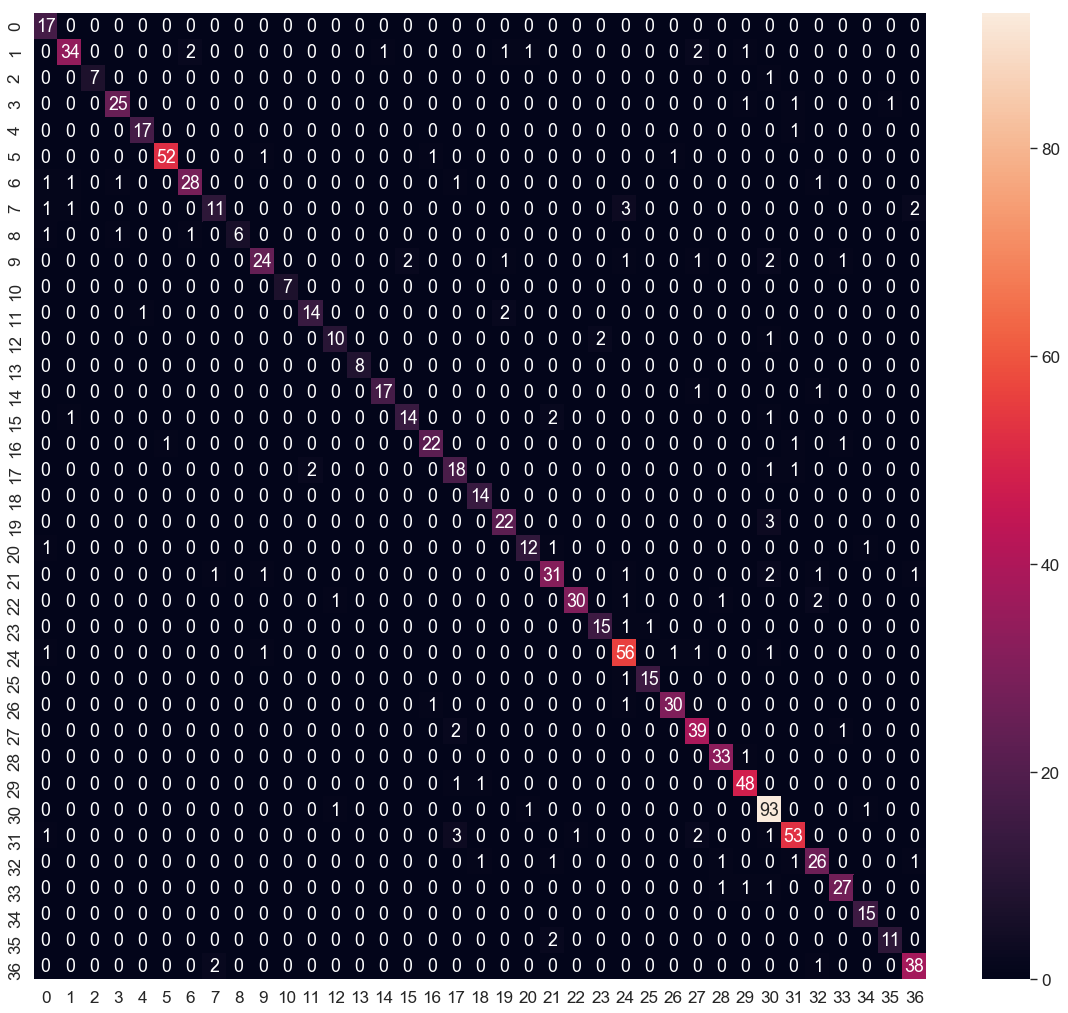

In [10]:
r_clf = RandomForestClassifier(n_estimators=100)
kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
i=1
for train_index, test_index in kf.split(train.iloc[:,:-1],train.iloc[:,-1]):
#     print("TRAIN:", train_index, "TEST:", test_index)
    print()
    print('-------fold '+str(i)+'--------')
    i +=1
    X_train, X_test = train.iloc[train_index,:-1], train.iloc[test_index,:-1]
    y_train, y_test = train.iloc[train_index,-1], train.iloc[test_index,-1]
    

    r_clf.fit(X_train, y_train.values.ravel())

    #### Accuracy

    predictions = r_clf.predict(X_test)
    print ("Train Accuracy :: ", accuracy_score(y_train, r_clf.predict(X_train)))
    print ("Validation Accuracy  :: ", accuracy_score(y_test, predictions))

    #### F1-Score

    print('F1-score: {0}'.format(f1_score(predictions, y_test,average='micro')))
    
print('-------------Test results--------------')
#### Accuracy

predictions = r_clf.predict(test.iloc[:,:-1])
print ("Test Accuracy  :: ", accuracy_score(test.iloc[:,-1], predictions))

#### F1-Score

print('F1-score: {0}'.format(f1_score(predictions, test.iloc[:,-1],average='micro')))
#### Confusion Matrix

conf_arr = confusion_matrix(test.iloc[:,-1],predictions)#.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(conf_arr)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

### MLP

In [ ]:
r_clf = MLPClassifier(activation='relu',max_iter=2000)
kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
i=1
for train_index, test_index in kf.split(train.iloc[:,:-1],train.iloc[:,-1]):
#     print("TRAIN:", train_index, "TEST:", test_index)
    print()
    print('-------fold '+str(i)+'--------')
    i +=1
    X_train, X_test = train.iloc[train_index,:-1], train.iloc[test_index,:-1]
    y_train, y_test = train.iloc[train_index,-1], train.iloc[test_index,-1]
    

    r_clf.fit(X_train, y_train.values.ravel())

    #### Accuracy

    predictions = r_clf.predict(X_test)
    print ("Train Accuracy :: ", accuracy_score(y_train, r_clf.predict(X_train)))
    print ("Validation Accuracy  :: ", accuracy_score(y_test, predictions))

    #### F1-Score

    print('F1-score: {0}'.format(f1_score(predictions, y_test,average='micro')))
    
print('-------------Test results--------------')
#### Accuracy

predictions = r_clf.predict(test.iloc[:,:-1])
print ("Test Accuracy  :: ", accuracy_score(test.iloc[:,-1], predictions))

#### F1-Score

print('F1-score: {0}'.format(f1_score(predictions, test.iloc[:,-1],average='micro')))
#### Confusion Matrix

conf_arr = confusion_matrix(test.iloc[:,-1],predictions)#.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(conf_arr)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size


-------fold 1--------
Train Accuracy ::  0.989884799100871
Validation Accuracy  ::  0.8353510895883777
F1-score: 0.8353510895883777

-------fold 2--------
Train Accuracy ::  0.9792193204156135
Validation Accuracy  ::  0.829683698296837
F1-score: 0.829683698296837

-------fold 3--------
Train Accuracy ::  0.9896213183730715
Validation Accuracy  ::  0.8304668304668305
F1-score: 0.8304668304668305

-------fold 4--------
Train Accuracy ::  0.9893438025799215
Validation Accuracy  ::  0.7955665024630542
F1-score: 0.7955665024630542

-------fold 5--------
Train Accuracy ::  0.9941225860621327
Validation Accuracy  ::  0.8571428571428571
F1-score: 0.8571428571428571

-------fold 6--------
Train Accuracy ::  0.9916130835896002
Validation Accuracy  ::  0.8329113924050633
F1-score: 0.8329113924050633

-------fold 7--------
Train Accuracy ::  0.9932960893854749
Validation Accuracy  ::  0.8367346938775511
F1-score: 0.8367346938775511

-------fold 8--------


### KNN


-------fold 1--------
Train Accuracy ::  0.918516437201461
Validation Accuracy  ::  0.7433414043583535
F1-score: 0.7433414043583535

-------fold 2--------
Train Accuracy ::  0.9196854816062904
Validation Accuracy  ::  0.781021897810219
F1-score: 0.781021897810219

-------fold 3--------
Train Accuracy ::  0.9133239831697054
Validation Accuracy  ::  0.7960687960687961
F1-score: 0.7960687960687961

-------fold 4--------
Train Accuracy ::  0.9178351093662367
Validation Accuracy  ::  0.7463054187192119
F1-score: 0.7463054187192119

-------fold 5--------
Train Accuracy ::  0.9137979289112791
Validation Accuracy  ::  0.8145363408521303
F1-score: 0.8145363408521303

-------fold 6--------
Train Accuracy ::  0.9172490914173889
Validation Accuracy  ::  0.7544303797468355
F1-score: 0.7544303797468355

-------fold 7--------
Train Accuracy ::  0.9187150837988827
Validation Accuracy  ::  0.7653061224489796
F1-score: 0.7653061224489794

-------fold 8--------
Train Accuracy ::  0.9190848214285714
Vali

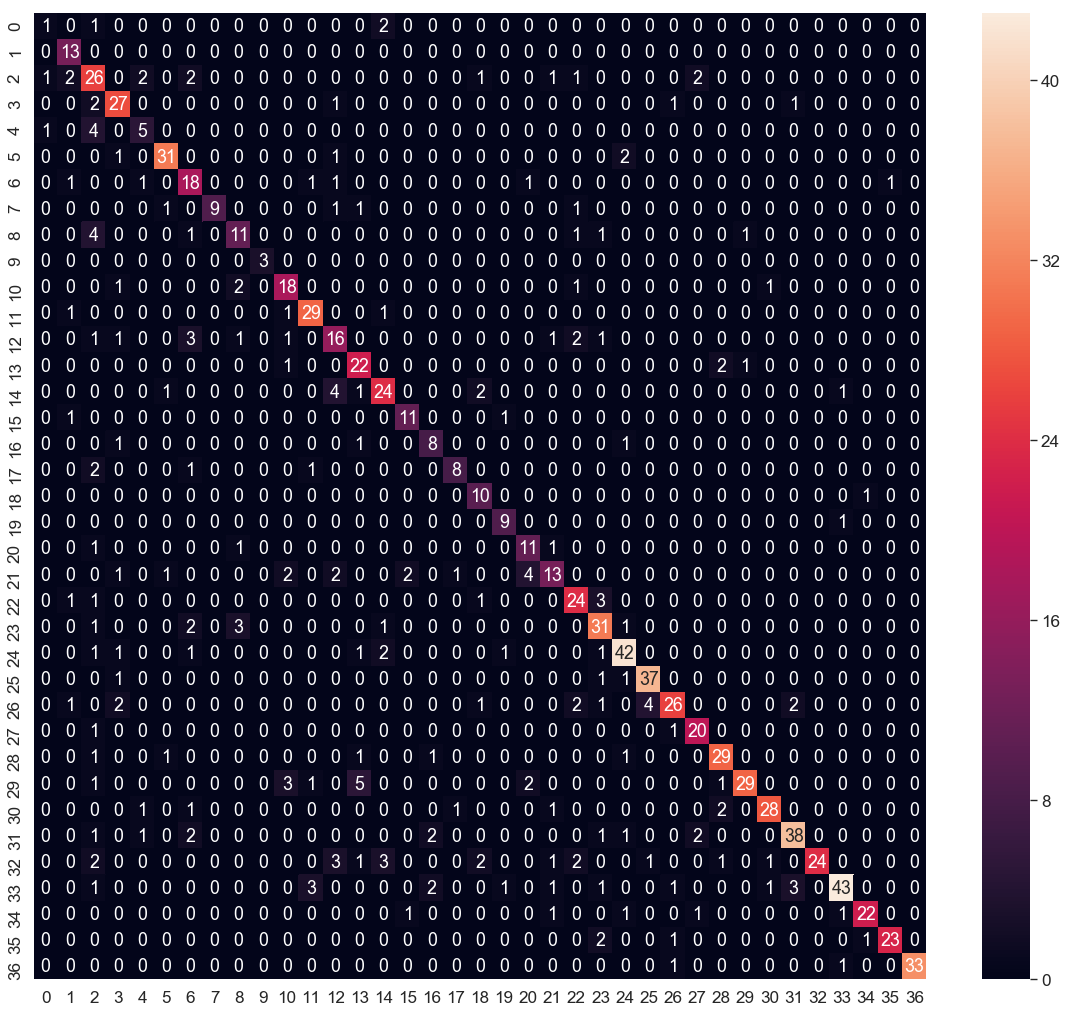

In [74]:
r_clf = KNeighborsClassifier(leaf_size=100,n_neighbors=2)
kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
i=1
for train_index, test_index in kf.split(train.iloc[:,:-1],train.iloc[:,-1]):
#     print("TRAIN:", train_index, "TEST:", test_index)
    print()
    print('-------fold '+str(i)+'--------')
    i +=1
    X_train, X_test = train.iloc[train_index,:-1], train.iloc[test_index,:-1]
    y_train, y_test = train.iloc[train_index,-1], train.iloc[test_index,-1]
    

    r_clf.fit(X_train, y_train.values.ravel())

    #### Accuracy

    predictions = r_clf.predict(X_test)
    print ("Train Accuracy :: ", accuracy_score(y_train, r_clf.predict(X_train)))
    print ("Validation Accuracy  :: ", accuracy_score(y_test, predictions))

    #### F1-Score

    print('F1-score: {0}'.format(f1_score(predictions, y_test,average='micro')))
    
print('-------------Test results--------------')
#### Accuracy

predictions = r_clf.predict(test.iloc[:,:-1])
print ("Test Accuracy  :: ", accuracy_score(test.iloc[:,-1], predictions))

#### F1-Score

print('F1-score: {0}'.format(f1_score(predictions, test.iloc[:,-1],average='micro')))
#### Confusion Matrix

conf_arr = confusion_matrix(test.iloc[:,-1],predictions)#.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(conf_arr)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

### RBF(SVC)


-------fold 1--------
Train Accuracy ::  0.9974711997752178
Validation Accuracy  ::  0.8353510895883777
F1-score: 0.8353510895883777

-------fold 2--------
Train Accuracy ::  0.9974726200505476
Validation Accuracy  ::  0.829683698296837
F1-score: 0.829683698296837

-------fold 3--------
Train Accuracy ::  0.9977559607293127
Validation Accuracy  ::  0.8648648648648649
F1-score: 0.8648648648648649

-------fold 4--------
Train Accuracy ::  0.9980370162647224
Validation Accuracy  ::  0.8325123152709359
F1-score: 0.8325123152709359

-------fold 5--------
Train Accuracy ::  0.9977609851665268
Validation Accuracy  ::  0.8596491228070176
F1-score: 0.8596491228070176

-------fold 6--------
Train Accuracy ::  0.9980430528375733
Validation Accuracy  ::  0.810126582278481
F1-score: 0.810126582278481

-------fold 7--------
Train Accuracy ::  0.9977653631284916
Validation Accuracy  ::  0.826530612244898
F1-score: 0.826530612244898

-------fold 8--------
Train Accuracy ::  0.9974888392857143
Validat

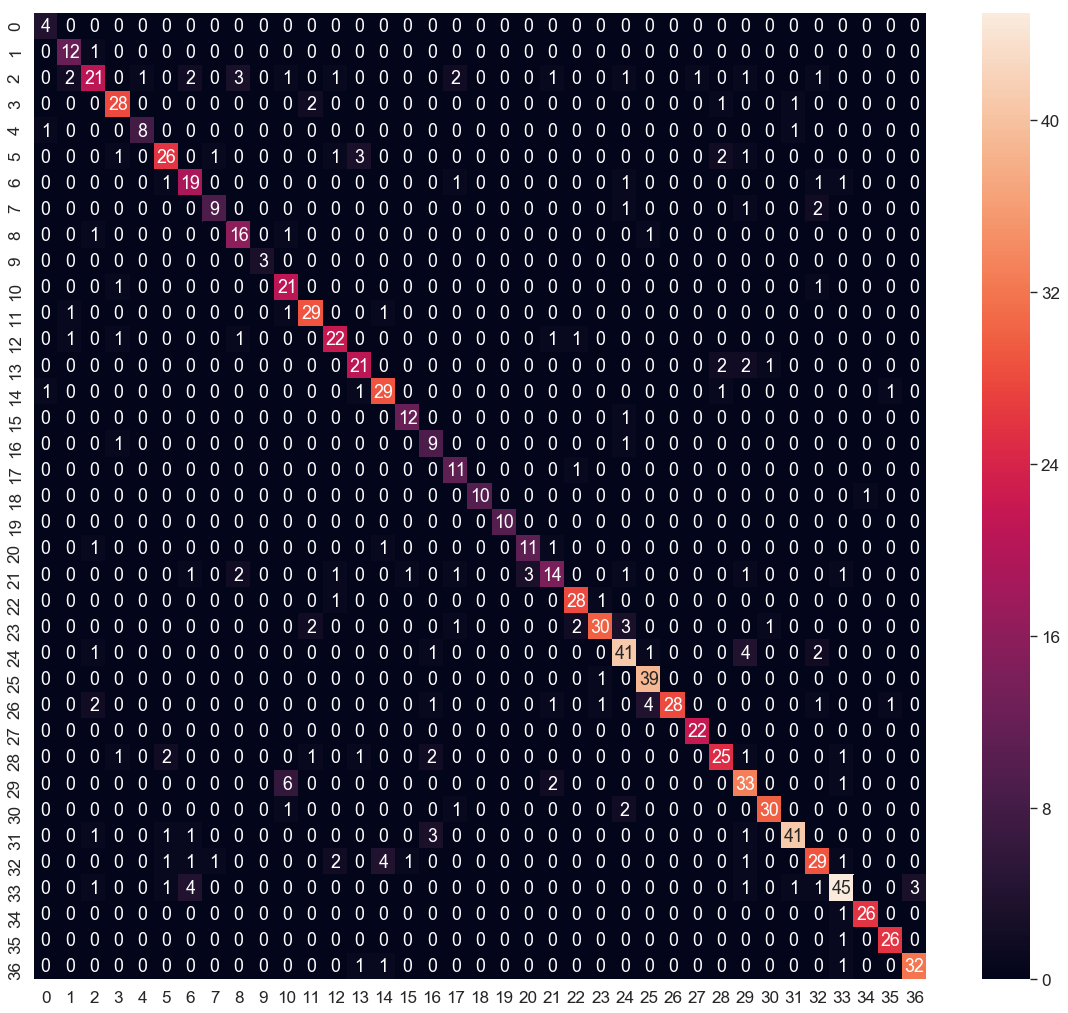

In [12]:
# From Gear1 to Gear15 where accuracy is less than 70%
r_clf = SVC(kernel='rbf', random_state=0, gamma=.01, C=100000)

#Else use down one
#r_clf = SVC(gamma='scale', decision_function_shape='ovo')
kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
i=1
for train_index, test_index in kf.split(train.iloc[:,:-1],train.iloc[:,-1]):
#     print("TRAIN:", train_index, "TEST:", test_index)
    print()
    print('-------fold '+str(i)+'--------')
    i +=1
    X_train, X_test = train.iloc[train_index,:-1], train.iloc[test_index,:-1]
    y_train, y_test = train.iloc[train_index,-1], train.iloc[test_index,-1]
    

    r_clf.fit(X_train, y_train.values.ravel())

    #### Accuracy

    predictions = r_clf.predict(X_test)
    print ("Train Accuracy :: ", accuracy_score(y_train, r_clf.predict(X_train)))
    print ("Validation Accuracy  :: ", accuracy_score(y_test, predictions))

    #### F1-Score

    print('F1-score: {0}'.format(f1_score(predictions, y_test,average='micro')))
    
print('-------------Test results--------------')
#### Accuracy

predictions = r_clf.predict(test.iloc[:,:-1])
print ("Test Accuracy  :: ", accuracy_score(test.iloc[:,-1], predictions))

#### F1-Score

print('F1-score: {0}'.format(f1_score(predictions, test.iloc[:,-1],average='micro')))
#### Confusion Matrix

conf_arr = confusion_matrix(test.iloc[:,-1],predictions)#.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(conf_arr)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

## Feature Pruning and Feature Selection

### Recursive Feature Elimination

In a dataset, not all features, contribute to the prediction variable. Removing features of low importance can improve accuracy, and reduce both model complexity and overfitting. Training time can also be reduced for very large datasets.
Lets remove such low importance features from our dataset using RFE from scikit-learn module.

#### Data Normalization

Lets Normalize data by using standard scaler(bring mean to 0 and standard deviation to 1) then apply RFE.

In [11]:
std_scaler = StandardScaler()
gear_ds_feature_dropped_scaled = gear_ds_feature_dropped.copy()
gear_ds_feature_dropped_scaled.iloc[:,:-1] = std_scaler.fit_transform(gear_ds_feature_dropped.iloc[:,:-1])

C:\Users\Jaspreet\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jaspreet\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [12]:
gear_ds_feature_dropped_scaled.head()

,MIC2,MIC3,MIC4,MIC5,MIC6,MIC7,MIC9,MIC10,MIC11,MIC12,...,ACO13,ACC1,ACC11,ACC13,ACC16,TEMP5,TEMP6,TEMP7,TEMP15,Class
0,-0.768629,-0.106958,-0.028081,-0.809797,-0.047768,0.259960,0.269686,-0.181085,0.006538,-0.775782,...,-0.092983,-0.162742,-1.651436,-0.408947,-0.162127,-0.423452,-1.767265,-0.428808,-0.689470,31
1,2.443757,-0.106958,-1.470432,-0.964686,-0.047768,0.298568,0.384525,-0.180588,0.187905,-0.794289,...,0.206376,-0.162742,1.653268,-1.148580,-0.162127,2.697669,1.666686,2.606153,-0.840147,24
2,-0.041654,-0.106958,-1.827454,0.447333,-0.047768,0.123220,0.038629,-0.181680,0.006538,0.469074,...,-0.195658,-0.162742,0.034209,0.199828,-0.162127,-0.419102,0.053317,-0.424530,0.278907,6
3,-0.041654,-0.106958,1.248210,0.266028,-0.047768,0.147351,0.080001,-0.181633,0.006538,0.291413,...,-0.195658,-0.162742,0.034209,0.164351,-0.162127,-0.413767,0.053317,-0.421592,0.141093,31
4,-0.041654,-0.106958,0.367276,-0.727557,-0.047768,0.286779,0.135132,-0.181216,0.006538,-0.725199,...,-0.195658,-0.162742,0.034209,-0.231293,-0.162127,-0.393735,0.053317,-0.405735,-0.616887,13


In [16]:
svm = SVC(kernel="linear")
# create the RFE model for the svm classifier 
# and select attributes
rfe = RFE(svm)

In [17]:
#For Big Data like Gear16 to Gear25 Use Random Forest with RFE
#Gear 25 I used svm but it's so much of time taking.

#clf = RandomForestClassifier(n_estimators=10)
# create the RFE model for the Random Forest classifier 
# and select attributes
#rfe = RFE(clf)

In [18]:
rfe = rfe.fit(gear_ds_feature_dropped_scaled.drop(['Class'],axis=1).values, gear_ds_feature_dropped_scaled[['Class']].values.ravel())
# print summaries for the selection of attributes
print(rfe.support_)
print(rfe.ranking_)

[False False  True  True  True False  True  True False  True  True  True
  True  True  True  True False  True False  True False False  True False
  True False False False  True  True  True  True  True False  True  True
 False False  True False False False False False False  True False False
 False False]
[ 6 18  1  1  1 20  1  1  3  1  1  1  1  1  1  1 24  1 21  1  8 16  1 14
  1 23 19 11  1  1  1  1  1 13  1  1 25 26  1 10 15 17  2 12  7  1 22  4
  9  5]


In [19]:
temp = pd.Series(rfe.support_,index = gear_ds_feature_dropped_scaled.drop(['Class'],axis=1).columns)


In [20]:
selected_features_rfe = temp[temp==True].index
print('from total features, RFE has stepped us down to '+str(len(selected_features_rfe))+' features. Selected Features by RFE are:')
selected_features_rfe = list(selected_features_rfe)
selected_features_rfe.append('Class')
print(selected_features_rfe)
gear_ds_rfe = gear_ds_feature_dropped[selected_features_rfe]
gear_ds_rfe_scaled = gear_ds_feature_dropped_scaled[selected_features_rfe]
gear_ds_rfe.shape

from total features, RFE has stepped us down to 25 features. Selected Features by RFE are:
['MIC4', 'MIC5', 'MIC7', 'MIC9', 'MIC10', 'MIC12', 'MIC15', 'MIC16', 'TRQ1', 'TRQ3', 'TRQ5', 'TRQ9', 'TRQ11', 'TRQ13', 'VIA3', 'VIA5', 'VIF2', 'VIF4', 'VIF6', 'VIF9', 'VIF12', 'VIB2', 'VIB4', 'VIB8', 'ACC13', 'Class']


(5115, 26)

In [21]:
print('We started with '+str(gear_ds.shape[1])+' features originally, after eliminiting highly correlated (more than 90%) and No variance features we were left with '+str(gear_ds_feature_dropped.shape[1])+' features, then we applied Recursive Feature Elimination to get rid of useless features and we end up with '+str(gear_ds_rfe.shape[1])+' features.')

We started with 131 features originally, after eliminiting highly correlated (more than 90%) and No variance features we were left with 51 features, then we applied Recursive Feature Elimination to get rid of useless features and we end up with 26 features.


In [22]:
print('And final list of features is :')
print(gear_ds_rfe.columns)

And final list of features is :
Index(['MIC4', 'MIC5', 'MIC7', 'MIC9', 'MIC10', 'MIC12', 'MIC15', 'MIC16',
       'TRQ1', 'TRQ3', 'TRQ5', 'TRQ9', 'TRQ11', 'TRQ13', 'VIA3', 'VIA5',
       'VIF2', 'VIF4', 'VIF6', 'VIF9', 'VIF12', 'VIB2', 'VIB4', 'VIB8',
       'ACC13', 'Class'],
      dtype='object')


- [Model Fitting](#Model-Fitting)
    - [Recursive Feature Elimination](#Recursive-Featre-Elimination)
        - [Random Forest Classifier](#Random-Forest-Classifier)
        - [MLP(Multilayer Perceptron)](#MLP(Multilayer-Perceptron))
        - [KNN Classifier](#KNN-Classifier)
        - [RBF(SVC)](#RBF(SVM))

### Lasso regularization

Lets Run Our data Subsetted already by RFE, from Lasso to see how many features can be eliminated by penality of lasso.

In [13]:
#alphas to be changed for Gear16 to Gear25
#Gear8, Gear17 to Gear25 Can Be Done By Elastic Penality(Lasso and Rasso)
#reg = LassoCV(alphas=[0.1],max_iter=5000,cv=10)

reg = LassoCV(max_iter=5000,cv=10)
reg.fit(gear_ds_feature_dropped_scaled.drop(['Class'],axis=1).values, gear_ds_feature_dropped_scaled[['Class']].values.ravel())
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(gear_ds_feature_dropped_scaled.drop(['Class'],axis=1).values, gear_ds_feature_dropped_scaled[['Class']].values.ravel()))
coef = pd.Series(reg.coef_, index = gear_ds_feature_dropped_scaled.drop(['Class'],axis=1).columns)

Best alpha using built-in LassoCV: 0.032564
Best score using built-in LassoCV: 0.086925


In [14]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 42 variables and eliminated the other 10 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

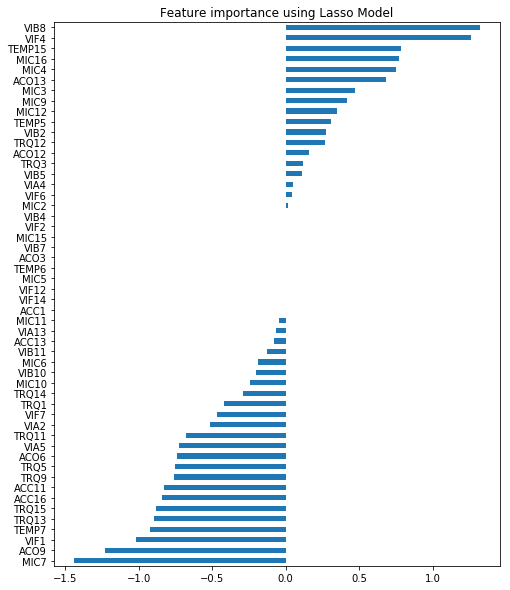

In [15]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [19]:
to_drop = []
for k,v in imp_coef.items():
    if v<=0.0:
        to_drop.append(k)
print('Removing variables the lasso indicated to be insignificant, which are: ')
print(to_drop)

Removing variables the lasso indicated to be insignificant, which are: 
['MIC7', 'ACO9', 'VIF1', 'TEMP7', 'TRQ13', 'TRQ15', 'ACC16', 'ACC11', 'TRQ9', 'TRQ5', 'ACO6', 'VIA5', 'TRQ11', 'VIA2', 'VIF7', 'TRQ1', 'TRQ14', 'MIC10', 'VIB10', 'MIC6', 'VIB11', 'ACC13', 'VIA13', 'MIC11', 'ACC1', 'VIF14', 'VIF12', 'MIC5', 'TEMP6', 'ACO3', 'VIB7', 'MIC15', 'VIF2', 'VIB4']


In [20]:
gear_ds_lasso = gear_ds_feature_dropped.drop(to_drop,axis=1)
gear_ds_lasso_scaled = gear_ds_feature_dropped_scaled.drop(to_drop,axis=1)
gear_ds_lasso.shape

(5271, 19)

In [21]:
gear_ds_lasso_scaled.shape

(5271, 19)

In [22]:
gear_ds_lasso.head()

,MIC2,MIC3,MIC4,MIC9,MIC12,MIC16,TRQ3,TRQ12,VIA4,VIF4,VIF6,VIB2,VIB5,VIB8,ACO12,ACO13,TEMP5,TEMP15,Class
0,-50.191103,0.0,4.199781,132735.6250,275.21433,179.192550,60.000000,0.0,0.00,132386.8656,60.000,60.000,0.0,-115.863525,0.00,4.880905,-3.073070,264.96017,31
1,171.595130,0.0,-141.812784,133290.0781,272.46768,41.161288,59.997002,0.0,0.01,132888.3310,59.997,59.997,0.0,98.216425,0.01,19.111633,3.082127,234.93013,24
2,0.000000,0.0,-177.954962,131620.0625,459.97232,-2.784575,59.999001,0.0,0.00,131283.6417,60.000,59.999,0.0,61.982574,0.00,0.000000,-3.064492,457.95811,6
3,0.000000,0.0,133.401763,131819.8125,433.60448,-51.783926,59.999001,0.0,0.00,131459.1546,60.000,59.999,0.0,13.326998,0.00,0.000000,-3.053969,430.49161,31
4,0.000000,0.0,44.222719,132085.9864,282.72184,-143.401802,60.001000,0.0,0.00,132311.6458,60.000,60.000,0.0,-75.779398,0.00,0.000000,-3.014464,279.42586,13


In [23]:
print('We started with '+str(gear_ds.shape[1])+' features originally, after eliminiting highly correlated (more than 90%) and No variance features we were left with '+str(gear_ds_feature_dropped.shape[1])+' features, then we applied L-0 Norm (Lasso) to get rid of useless features and we end up with '+str(gear_ds_lasso.shape[1])+' features.')

We started with 131 features originally, after eliminiting highly correlated (more than 90%) and No variance features we were left with 53 features, then we applied L-0 Norm (Lasso) to get rid of useless features and we end up with 19 features.


In [24]:
print('And final list of features is :')
print(gear_ds_lasso.columns)

And final list of features is :
Index(['MIC2', 'MIC3', 'MIC4', 'MIC9', 'MIC12', 'MIC16', 'TRQ3', 'TRQ12',
       'VIA4', 'VIF4', 'VIF6', 'VIB2', 'VIB5', 'VIB8', 'ACO12', 'ACO13',
       'TEMP5', 'TEMP15', 'Class'],
      dtype='object')


- [Model Fitting](#Model-Fitting)
    - [Lasso regularization](#Lasso-regularization)
        - [Random Forest Classifier](#Random-Forest-Classifier)
        - [MLP(Multilayer Perceptron)](#MLP(Multilayer-Perceptron))
        - [KNN Classifier](#KNN-Classifier)
        - [RBF(SVC)](#RBF(SVM))

### Feature selection using fischer score

Fisher score or F-Scores is a measure of how informative each feature is for your dataset. Lets apply on out selected data from rfe and then lasso to see how informative those selected features are to our target.

In [32]:
test = SelectKBest(k='all')
fit = test.fit(gear_ds_feature_dropped_scaled.drop(['Class'],axis=1).values, gear_ds_feature_dropped_scaled[['Class']].values.ravel())
# summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

[ 7.387  3.338 24.512 15.554  4.278  5.018  6.525 12.414  1.329 15.866
  2.899 11.682  8.425  0.618  8.796  7.032 10.794 28.923  1.02  31.301
  6.275 12.338 37.944  1.037  3.607  1.116  9.417  9.669 20.795  5.528
  0.564  2.451  3.851  7.924  1.528 39.081  0.86   0.856 35.194  7.62
  8.691  9.769  0.701 11.258 10.189  6.691 14.777  3.378  9.799 11.093]


##### It is pretty evident that there are still some features with less Fisher score, lets remove them as well.

In [33]:
coef = pd.Series(fit.scores_, index = gear_ds_feature_dropped_scaled.drop(['Class'],axis=1).columns)

In [34]:
coef[coef>5.0]

MIC2      7.387487
MIC4     24.512471
MIC5     15.554265
MIC8      5.017616
MIC9      6.524974
MIC10    12.414082
MIC12    15.865809
MIC16    11.681907
TRQ1      8.425146
TRQ5      8.795650
TRQ9      7.032174
TRQ10    10.794239
TRQ11    28.923240
TRQ13    31.301100
TRQ14     6.274522
TRQ15    12.337899
VIA3     37.943553
VIA16     9.416889
VIF1      9.668719
VIF2     20.794717
VIF4      5.527865
VIF14     7.923858
VIB4     39.081421
VIB8     35.193546
VIB10     7.620205
VIB11     8.690680
ACO9      9.769138
ACC1     11.258426
ACC11    10.189047
ACC13     6.691339
ACC16    14.777147
TEMP6     9.799230
TEMP7    11.093021
dtype: float64

lets select top features having more than 0.5 Fisher score.

In [35]:
coef_top = coef[coef>5.0]

In [36]:
coef_top

MIC2      7.387487
MIC4     24.512471
MIC5     15.554265
MIC8      5.017616
MIC9      6.524974
MIC10    12.414082
MIC12    15.865809
MIC16    11.681907
TRQ1      8.425146
TRQ5      8.795650
TRQ9      7.032174
TRQ10    10.794239
TRQ11    28.923240
TRQ13    31.301100
TRQ14     6.274522
TRQ15    12.337899
VIA3     37.943553
VIA16     9.416889
VIF1      9.668719
VIF2     20.794717
VIF4      5.527865
VIF14     7.923858
VIB4     39.081421
VIB8     35.193546
VIB10     7.620205
VIB11     8.690680
ACO9      9.769138
ACC1     11.258426
ACC11    10.189047
ACC13     6.691339
ACC16    14.777147
TEMP6     9.799230
TEMP7    11.093021
dtype: float64

Lets further subset our dataset on the basis of these columns found significant on the basis of Fisher Score.

In [37]:
fisher_features = coef_top.keys().tolist()
fisher_features.append('Class')
gear_ds_fscore = gear_ds_feature_dropped[fisher_features]
gear_ds_fscore_scaled = gear_ds_feature_dropped_scaled[fisher_features]
gear_ds_fscore_scaled.shape

(5115, 34)

### Summary

In [38]:
print('We started with '+str(gear_ds.shape[1])+' features originally, after eliminiting highly correlated (more than 90%) and No variance features we were left with '+str(gear_ds_feature_dropped.shape[1])+' features, then we applied Fisher Score to get rid of useless features and we end up with '+str(gear_ds_fscore.shape[1])+' features.')

We started with 131 features originally, after eliminiting highly correlated (more than 90%) and No variance features we were left with 51 features, then we applied Fisher Score to get rid of useless features and we end up with 34 features.


In [39]:
print('And final list of features is :')
print(gear_ds_fscore.columns)

And final list of features is :
Index(['MIC2', 'MIC4', 'MIC5', 'MIC8', 'MIC9', 'MIC10', 'MIC12', 'MIC16',
       'TRQ1', 'TRQ5', 'TRQ9', 'TRQ10', 'TRQ11', 'TRQ13', 'TRQ14', 'TRQ15',
       'VIA3', 'VIA16', 'VIF1', 'VIF2', 'VIF4', 'VIF14', 'VIB4', 'VIB8',
       'VIB10', 'VIB11', 'ACO9', 'ACC1', 'ACC11', 'ACC13', 'ACC16', 'TEMP6',
       'TEMP7', 'Class'],
      dtype='object')


## Final Remarks:
We are applied all those 3 techniques to our initial data set(52 columns) and created 3 different data sets using different filtering criterias. Now, lets apply classification methods on these 3 datasets and lets compare results.

- [Model Fitting](#Model-Fitting)
    - [Feature selection using fischer score](#Feature-selection-using-fischer-score)
        - [Random Forest Classifier](#Random-Forest-Classifier)
        - [MLP(Multilayer Perceptron)](#MLP(Multilayer-Perceptron))
        - [KNN Classifier](#KNN-Classifier)
        - [RBF(SVC)](#RBF(SVM))

## Model Fitting

### Recursive Feature Elimination

#### Split Data

Lets create training, test and validation with ratio of 60%, 20%, 20% respectively.

In [26]:
# Y = label_binarize(test_y, classes=gear_ds_fscore['Class'].unique())
train,test = train_test_split(gear_ds_rfe_scaled, test_size=0.2, random_state=1,stratify=gear_ds_rfe_scaled[['class']])

# train_x, validate_x, train_y, validate_y = train_test_split(train_x, train_y, test_size=0.25, random_state=1,stratify=train_y)
# train, validate, test = np.split(gear_ds_fscore.sample(frac=1), [int(.6*len(gear_ds_fscore)), int(.8*len(gear_ds_fscore))])
# train_x, train_y = train.drop(['Class'],axis=1),train[['Class']]
# validate_x, validate_y = validate.drop(['Class'],axis=1),validate[['Class']]
# test_x, test_y = test.drop(['Class'],axis=1),test[['Class']]

NameError: name 'gear_ds_rfe_scaled' is not defined

In [24]:
print ("Train Shape :: ", train.shape)
# print ("Train_y Shape :: ", train_y.shape)
print ("Test Shape :: ", test.shape)
# print ("Test_y Shape :: ", test_y.shape)
# print ("validate_x Shape :: ", validate_x.shape)
# print ("validate_x Shape :: ", validate_y.shape)

NameError: name 'train' is not defined

#### Random Forest Classifier

Lets fit RandomForestClassifier with CrossValidation 10 and look at its Accuracy, Confusion Matrix and ROC Curve

In [52]:
r_clf = RandomForestClassifier(n_estimators=100)
kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
i=1
for train_index, test_index in kf.split(train.iloc[:,:-1],train.iloc[:,-1]):
#     print("TRAIN:", train_index, "TEST:", test_index)
    print()
    print('-------fold '+str(i)+'--------')
    i +=1
    X_train, X_test = train.iloc[train_index,:-1], train.iloc[test_index,:-1]
    y_train, y_test = train.iloc[train_index,-1], train.iloc[test_index,-1]
    

    r_clf.fit(X_train, y_train.values.ravel())

    #### Accuracy

    predictions = r_clf.predict(X_test)
    print ("Train Accuracy :: ", accuracy_score(y_train, r_clf.predict(X_train)))
    print ("Validation Accuracy  :: ", accuracy_score(y_test, predictions))

    #### F1-Score

    print('F1-score: {0}'.format(f1_score(predictions, y_test,average='micro')))


-------fold 1--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.910411622276029
F1-score: 0.910411622276029

-------fold 2--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.9245742092457421
F1-score: 0.9245742092457421

-------fold 3--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.918918918918919
F1-score: 0.918918918918919

-------fold 4--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8916256157635468
F1-score: 0.8916256157635468

-------fold 5--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.9273182957393483
F1-score: 0.9273182957393483

-------fold 6--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8886075949367088
F1-score: 0.8886075949367088

-------fold 7--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8801020408163265
F1-score: 0.8801020408163264

-------fold 8--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.884020618556701
F1-score: 0.8840206185567009

-------fold 9--------
Train Accuracy ::  1.0
Validat

#### Accuracy

In [33]:
predictions = r_clf.predict(test.iloc[:,:-1])
print ("Test Accuracy  :: ", accuracy_score(test.iloc[:,-1], predictions))

Test Accuracy  ::  0.9077398594292488


#### F1-Score

In [70]:
print('F1-score: {0}'.format(f1_score(predictions, test.iloc[:,-1],average='micro')))

F1-score: 0.9014084507042254


#### Confusion Matrix

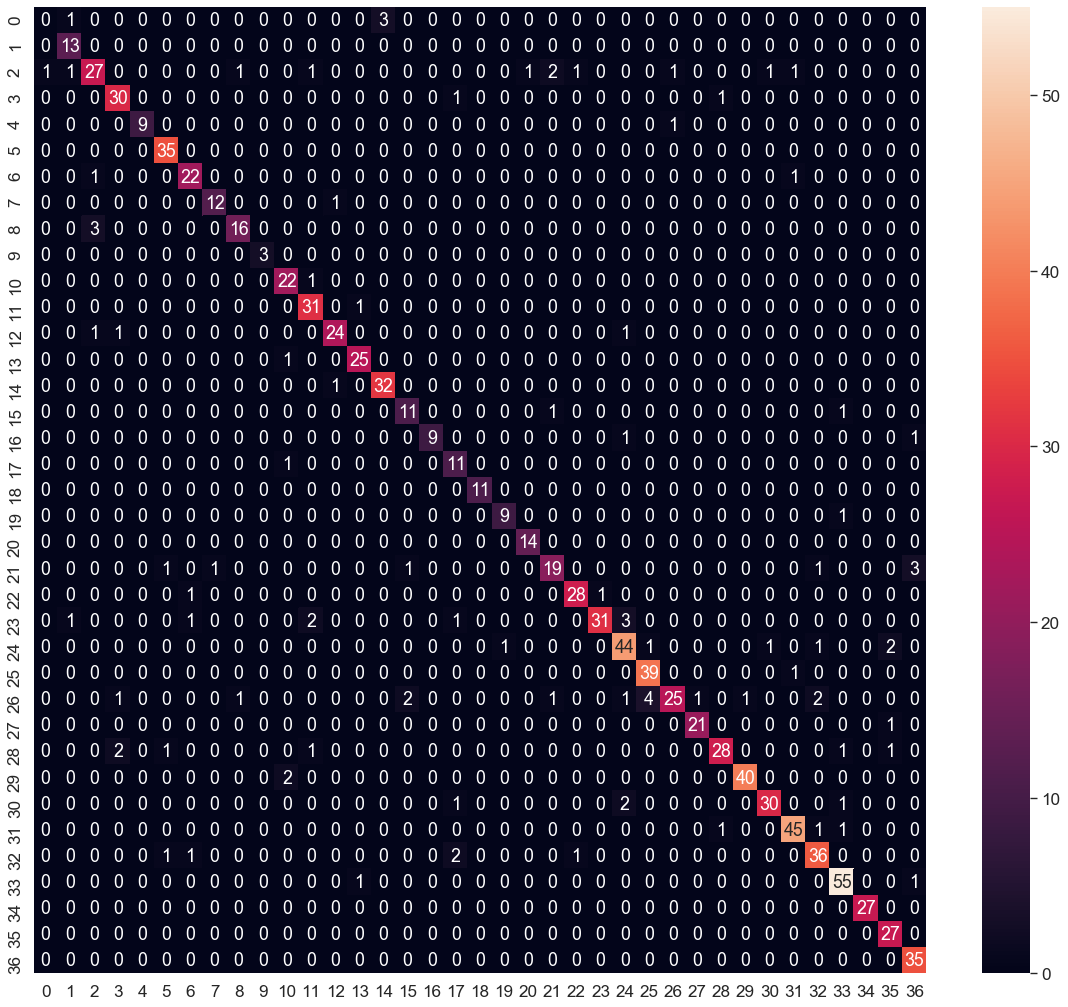

In [71]:
conf_arr = confusion_matrix(test.iloc[:,-1],predictions)#.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(conf_arr)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size


As one can see, all the predictions are just one constant number, which means Radial Basis Fucntion network was not able to train accuratley on this data.

### ROC Curve

For multi class problems like this one, the ROC curve is not a suitable choice to see the output/ accuracy of model, Logistic regression and Binary classification problem do support ROC curve ploting.

In [ ]:
# R.par(mfrow=[2,1])
# rsnns.plotIterativeError(model)
# R.plot(train_x, train_y.values.ravel())
# R.lines(train_x, R.fitted(model), col="green")

#### MLP(Multilayer Perceptron)

Lets fit MLPClassifier with CrossValidation 10 and look at its Accuracy, Confusion Matrix

In [77]:
clf = MLPClassifier(activation='relu',max_iter=2000)

kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
i=1
for train_index, test_index in kf.split(train.iloc[:,:-1],train.iloc[:,-1]):
#     print("TRAIN:", train_index, "TEST:", test_index)
    print()
    print('-------fold '+str(i)+'--------')
    i +=1
    X_train, X_test = train.iloc[train_index,:-1], train.iloc[test_index,:-1]
    y_train, y_test = train.iloc[train_index,-1], train.iloc[test_index,-1]
    

    clf.fit(X_train, y_train.values.ravel())

    #### Accuracy

    predictions = clf.predict(X_test)
    print ("Train Accuracy :: ", accuracy_score(y_train, clf.predict(X_train)))
    print ("Validation Accuracy  :: ", accuracy_score(y_test, predictions))

    #### F1-Score

    print('F1-score: {0}'.format(f1_score(predictions, y_test,average='micro')))


-------fold 1--------
Train Accuracy ::  0.9052244683644001
Validation Accuracy  ::  0.7516930022573364
F1-score: 0.7516930022573364

-------fold 2--------
Train Accuracy ::  0.9436287362349239
Validation Accuracy  ::  0.7899543378995434
F1-score: 0.7899543378995434

-------fold 3--------
Train Accuracy ::  0.9782949790794979
Validation Accuracy  ::  0.8084112149532711
F1-score: 0.808411214953271

-------fold 4--------
Train Accuracy ::  0.9738562091503268
Validation Accuracy  ::  0.8056206088992974
F1-score: 0.8056206088992973

-------fold 5--------
Train Accuracy ::  0.9832767180559184
Validation Accuracy  ::  0.8235294117647058
F1-score: 0.8235294117647058

-------fold 6--------
Train Accuracy ::  0.981974921630094
Validation Accuracy  ::  0.8231132075471698
F1-score: 0.8231132075471698

-------fold 7--------
Train Accuracy ::  0.9900757377905458
Validation Accuracy  ::  0.8321513002364066
F1-score: 0.8321513002364066

-------fold 8--------
Train Accuracy ::  0.9804330811374902
Val

#### Accuracy

In [74]:
predictions = clf.predict(test.iloc[:,:-1])
print ("Test Accuracy  :: ", accuracy_score(test.iloc[:,-1], predictions))

Test Accuracy  ::  0.8933601609657947


#### F1-Score

In [75]:
print('F1-score: {0}'.format(f1_score(predictions, test.iloc[:,-1],average='micro')))

F1-score: 0.8933601609657947


#### Confusion Matrix

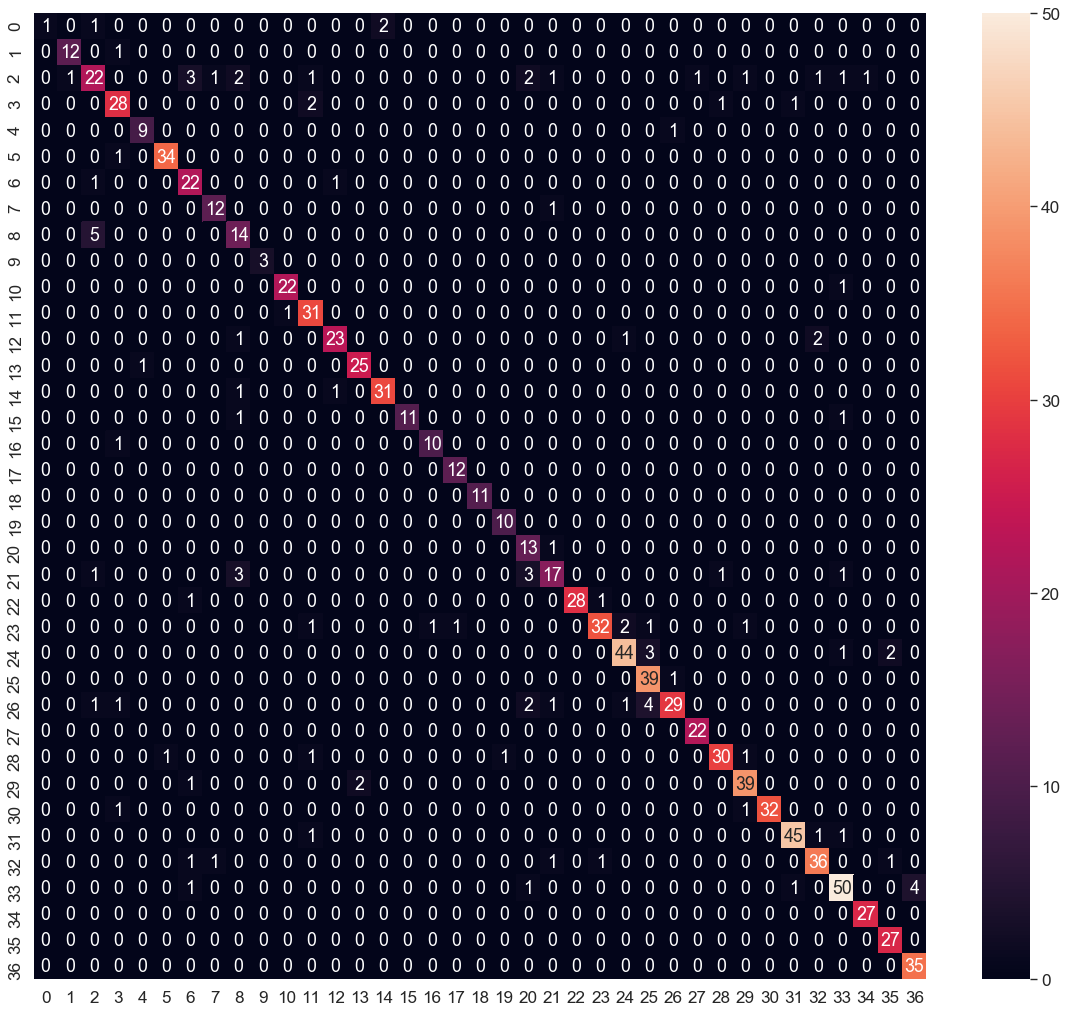

In [76]:
conf_arr = confusion_matrix(test.iloc[:,-1],predictions)#.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(conf_arr)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

#### KNN Classifier

Lets fit KNN Classifier with CrossValidation 10 and look at its Accuracy, Confusion Matrix

In [78]:
clf = KNeighborsClassifier(leaf_size=100,n_neighbors=5)

kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
i=1
for train_index, test_index in kf.split(train.iloc[:,:-1],train.iloc[:,-1]):
#     print("TRAIN:", train_index, "TEST:", test_index)
    print()
    print('-------fold '+str(i)+'--------')
    i +=1
    X_train, X_test = train.iloc[train_index,:-1], train.iloc[test_index,:-1]
    y_train, y_test = train.iloc[train_index,-1], train.iloc[test_index,-1]
    

    clf.fit(X_train, y_train.values.ravel())

    #### Accuracy

    predictions = clf.predict(X_test)
    print ("Train Accuracy :: ", accuracy_score(y_train, clf.predict(X_train)))
    print ("Validation Accuracy  :: ", accuracy_score(y_test, predictions))

    #### F1-Score

    print('F1-score: {0}'.format(f1_score(predictions, y_test,average='micro')))


-------fold 1--------
Train Accuracy ::  0.8177999474927803
Validation Accuracy  ::  0.6772009029345373
F1-score: 0.6772009029345373

-------fold 2--------
Train Accuracy ::  0.8190875721027793
Validation Accuracy  ::  0.7146118721461188
F1-score: 0.7146118721461188

-------fold 3--------
Train Accuracy ::  0.810407949790795
Validation Accuracy  ::  0.6705607476635514
F1-score: 0.6705607476635514

-------fold 4--------
Train Accuracy ::  0.8209150326797385
Validation Accuracy  ::  0.6721311475409836
F1-score: 0.6721311475409836

-------fold 5--------
Train Accuracy ::  0.8147373922132218
Validation Accuracy  ::  0.6847058823529412
F1-score: 0.6847058823529412

-------fold 6--------
Train Accuracy ::  0.8098223615464994
Validation Accuracy  ::  0.6981132075471698
F1-score: 0.6981132075471698

-------fold 7--------
Train Accuracy ::  0.8127448419952991
Validation Accuracy  ::  0.7044917257683215
F1-score: 0.7044917257683215

-------fold 8--------
Train Accuracy ::  0.8244195147404122
Va

#### Accuracy

In [78]:
predictions = clf.predict(test.iloc[:,:-1])
print ("Test Accuracy  :: ", accuracy_score(test.iloc[:,-1], predictions))

Test Accuracy  ::  0.8138832997987927


#### F1-Score

In [79]:
print('F1-score: {0}'.format(f1_score(predictions, test.iloc[:,-1],average='micro')))

F1-score: 0.8138832997987927


#### Confusion Matrix

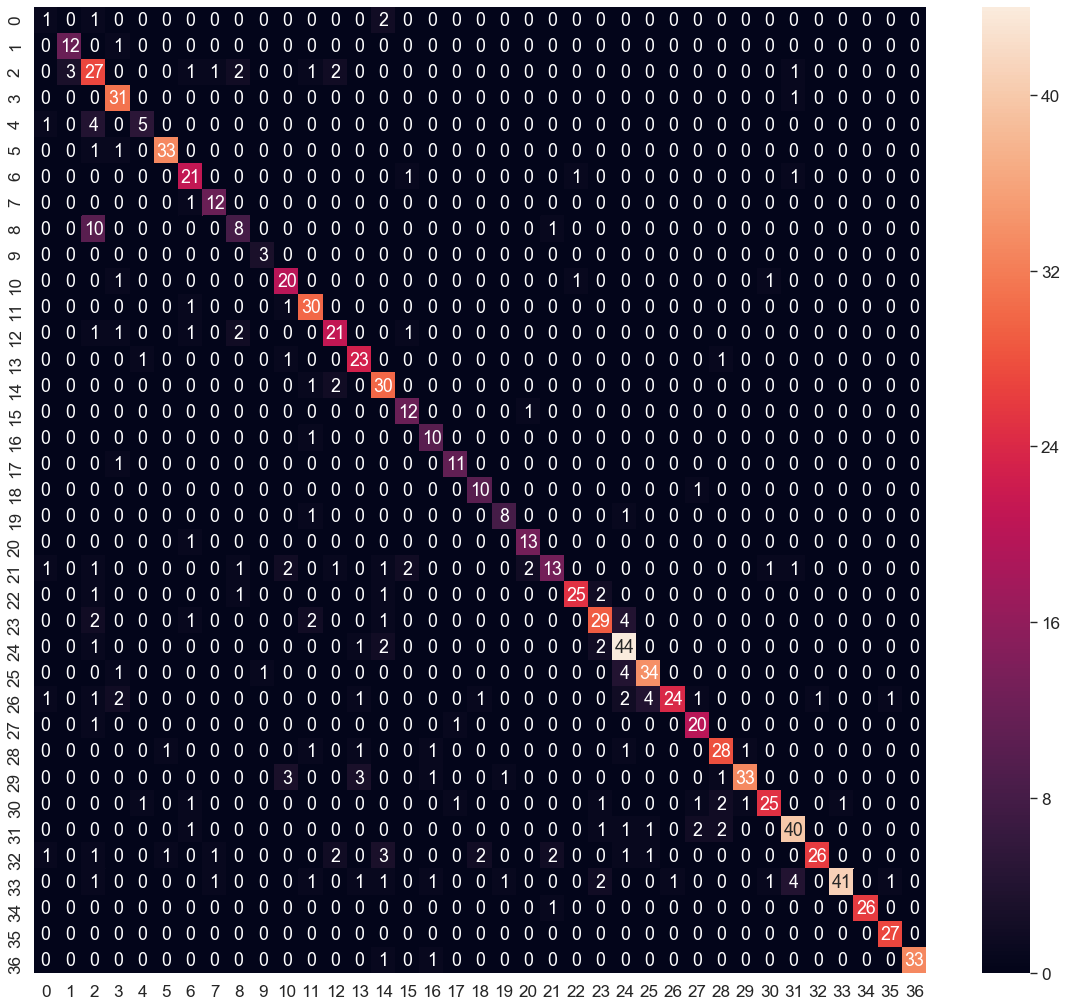

In [80]:
conf_arr = confusion_matrix(test.iloc[:,-1],predictions)#.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(conf_arr)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

#### RBF(SVC)

Lets fit SVC Classifier(RBF) with CrossValidation 10 and look at its Accuracy, Confusion Matrix

In [50]:
# From Gear1 to Gear15 where accuracy is less than 70%
clf = SVC(kernel='rbf', random_state=0, gamma=.01, C=100000)

#Else use down one
#clf = SVC(gamma='scale', decision_function_shape='ovo')

kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
i=1
for train_index, test_index in kf.split(train.iloc[:,:-1],train.iloc[:,-1]):
#     print("TRAIN:", train_index, "TEST:", test_index)
    print()
    print('-------fold '+str(i)+'--------')
    i +=1
    X_train, X_test = train.iloc[train_index,:-1], train.iloc[test_index,:-1]
    y_train, y_test = train.iloc[train_index,-1], train.iloc[test_index,-1]
    

    clf.fit(X_train, y_train.values.ravel())

    #### Accuracy

    predictions = clf.predict(X_test)
    print ("Train Accuracy :: ", accuracy_score(y_train, clf.predict(X_train)))
    print ("Validation Accuracy  :: ", accuracy_score(y_test, predictions))

    #### F1-Score

    print('F1-score: {0}'.format(f1_score(predictions, y_test,average='micro')))


-------fold 1--------
Train Accuracy ::  0.9957604663487016
Validation Accuracy  ::  0.9095022624434389
F1-score: 0.9095022624434389

-------fold 2--------
Train Accuracy ::  0.9947131905894793
Validation Accuracy  ::  0.8960739030023095
F1-score: 0.8960739030023096

-------fold 3--------
Train Accuracy ::  0.9957739038563127
Validation Accuracy  ::  0.8930232558139535
F1-score: 0.8930232558139535

-------fold 4--------
Train Accuracy ::  0.9968329374505146
Validation Accuracy  ::  0.9156908665105387
F1-score: 0.9156908665105387

-------fold 5--------
Train Accuracy ::  0.996309963099631
Validation Accuracy  ::  0.9028436018957346
F1-score: 0.9028436018957346

-------fold 6--------
Train Accuracy ::  0.9957850368809273
Validation Accuracy  ::  0.8928571428571429
F1-score: 0.8928571428571429

-------fold 7--------
Train Accuracy ::  0.9960547080483956
Validation Accuracy  ::  0.9251207729468599
F1-score: 0.9251207729468599

-------fold 8--------
Train Accuracy ::  0.9955298448593216
Va

#### Accuracy

In [83]:
predictions = clf.predict(test.iloc[:,:-1])
print ("Test Accuracy  :: ", accuracy_score(test.iloc[:,-1], predictions))

Test Accuracy  ::  0.2676056338028169


#### F1-Score

In [84]:
print('F1-score: {0}'.format(f1_score(predictions, test.iloc[:,-1],average='micro')))

F1-score: 0.2676056338028169


#### Confusion Matrix

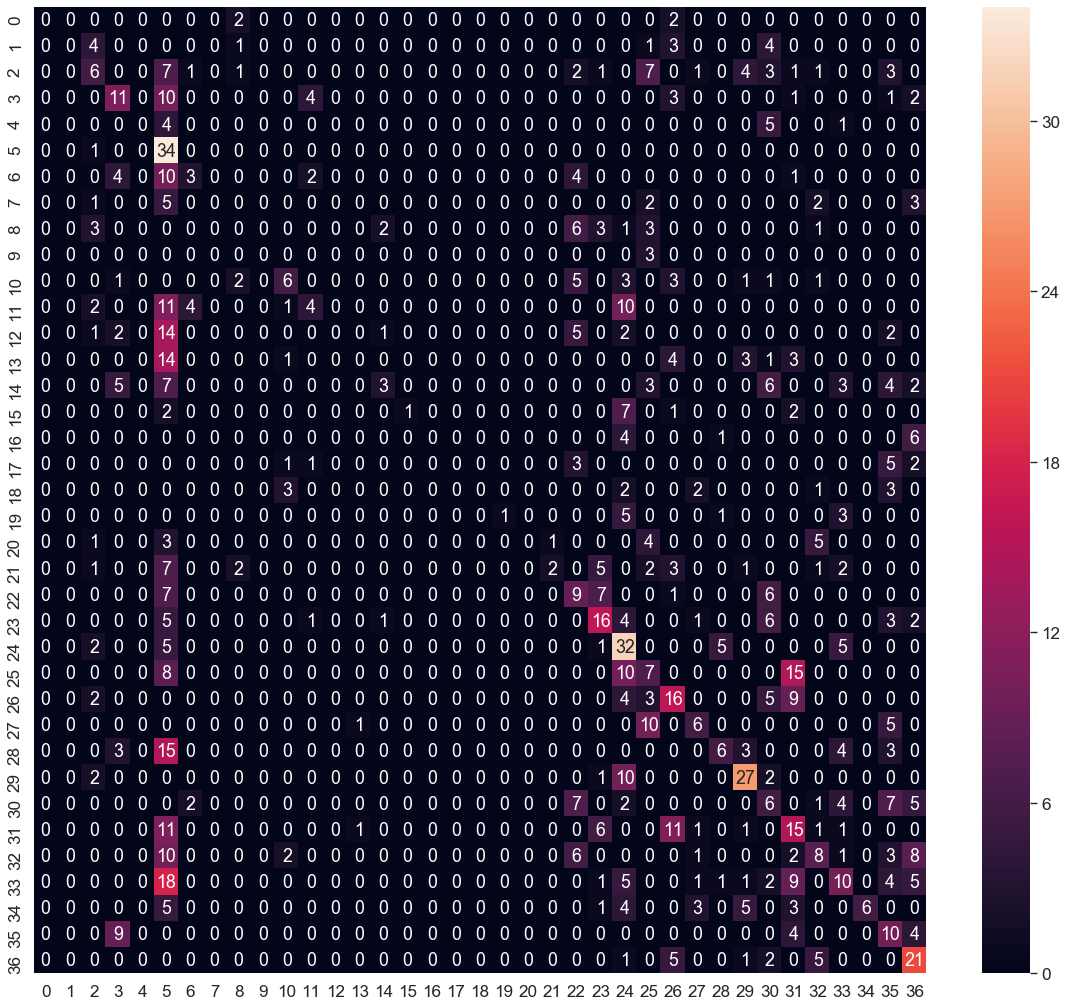

In [85]:
conf_arr = confusion_matrix(test.iloc[:,-1],predictions)#.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(conf_arr)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [66]:
#utils = importr('utils')
#utils.install_packages('RSNNS')

In [67]:
#rsnns = importr('RSNNS')

In [68]:
#model = rsnns.rbf(X_train, y_train.values.ravel(),size=40, maxit = 1000)

In [69]:
#R.predict(model, X_train, classification=True)

In [70]:
# # predictions = model.predict(test_x)
#predictions = R.predict(model, X_test)
#print ("Train Accuracy :: ", accuracy_score(y_train, np.array(R.predict(model, X_train))))
#print ("Test Accuracy  :: ", accuracy_score(y_test, np.array(predictions)))

In [71]:
#predictions

As one can see, all the predictions are just one constant number, which means Radial Basis Fucntion network was not able to train accuratley on this data.

### ROC Curve

For multi class problems like this one, the ROC curve is not a suitable choice to see the output/ accuracy of model, Logistic regression and Binary classification problem do support ROC curve ploting.

In [72]:
#R.par(mfrow=[2,1])
#rsnns.plotIterativeError(model)
#R.plot(X_train, y_train.values.ravel())
#R.lines(X_train, R.fitted(model), col="green")

### Lasso regularization

#### Split Data

Lets create training, test and validation with ratio of 60%, 20%, 20% respectively.

In [25]:
# Y = label_binarize(test_y, classes=gear_ds_fscore['Class'].unique())
train,test = train_test_split(gear_ds_lasso_scaled, test_size=0.2, random_state=1,stratify=gear_ds_lasso_scaled[['Class']])

# train_x, validate_x, train_y, validate_y = train_test_split(train_x, train_y, test_size=0.25, random_state=1,stratify=train_y)
# train, validate, test = np.split(gear_ds_fscore.sample(frac=1), [int(.6*len(gear_ds_fscore)), int(.8*len(gear_ds_fscore))])
# train_x, train_y = train.drop(['Class'],axis=1),train[['Class']]
# validate_x, validate_y = validate.drop(['Class'],axis=1),validate[['Class']]
# test_x, test_y = test.drop(['Class'],axis=1),test[['Class']]

print ("Train Shape :: ", train.shape)
# print ("Train_y Shape :: ", train_y.shape)
print ("Test Shape :: ", test.shape)
# print ("Test_y Shape :: ", test_y.shape)
# print ("validate_x Shape :: ", validate_x.shape)
# print ("validate_x Shape :: ", validate_y.shape)

Train Shape ::  (4216, 19)
Test Shape ::  (1055, 19)


#### Random Forest Classifier

Lets fit RandomForestClassifier with CrossValidation 10 and look at its Accuracy, Confusion Matrix and ROC Curve

In [52]:
clf = RandomForestClassifier(n_estimators=100)
kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
i=1
for train_index, test_index in kf.split(train.iloc[:,:-1],train.iloc[:,-1]):
#     print("TRAIN:", train_index, "TEST:", test_index)
    print()
    print('-------fold '+str(i)+'--------')
    i +=1
    X_train, X_test = train.iloc[train_index,:-1], train.iloc[test_index,:-1]
    y_train, y_test = train.iloc[train_index,-1], train.iloc[test_index,-1]
    

    clf.fit(X_train, y_train.values.ravel())

    #### Accuracy

    predictions = clf.predict(X_test)
    print ("Train Accuracy :: ", accuracy_score(y_train, clf.predict(X_train)))
    print ("Validation Accuracy  :: ", accuracy_score(y_test, predictions))

    #### F1-Score

    print('F1-score: {0}'.format(f1_score(predictions, y_test,average='micro')))


-------fold 1--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8893905191873589
F1-score: 0.8893905191873589

-------fold 2--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.906392694063927
F1-score: 0.906392694063927

-------fold 3--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.9042056074766355
F1-score: 0.9042056074766355

-------fold 4--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8875878220140515
F1-score: 0.8875878220140515

-------fold 5--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.9176470588235294
F1-score: 0.9176470588235294

-------fold 6--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.910377358490566
F1-score: 0.910377358490566

-------fold 7--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8747044917257684
F1-score: 0.8747044917257684

-------fold 8--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8902147971360382
F1-score: 0.8902147971360382

-------fold 9--------
Train Accuracy ::  1.0
Valida

#### Accuracy

In [92]:
predictions = clf.predict(test.iloc[:,:-1])
print ("Test Accuracy  :: ", accuracy_score(test.iloc[:,-1], predictions))

Test Accuracy  ::  0.8742454728370221


#### F1-Score

In [93]:
print('F1-score: {0}'.format(f1_score(predictions, test.iloc[:,-1],average='micro')))

F1-score: 0.8742454728370221


#### Confusion Matrix

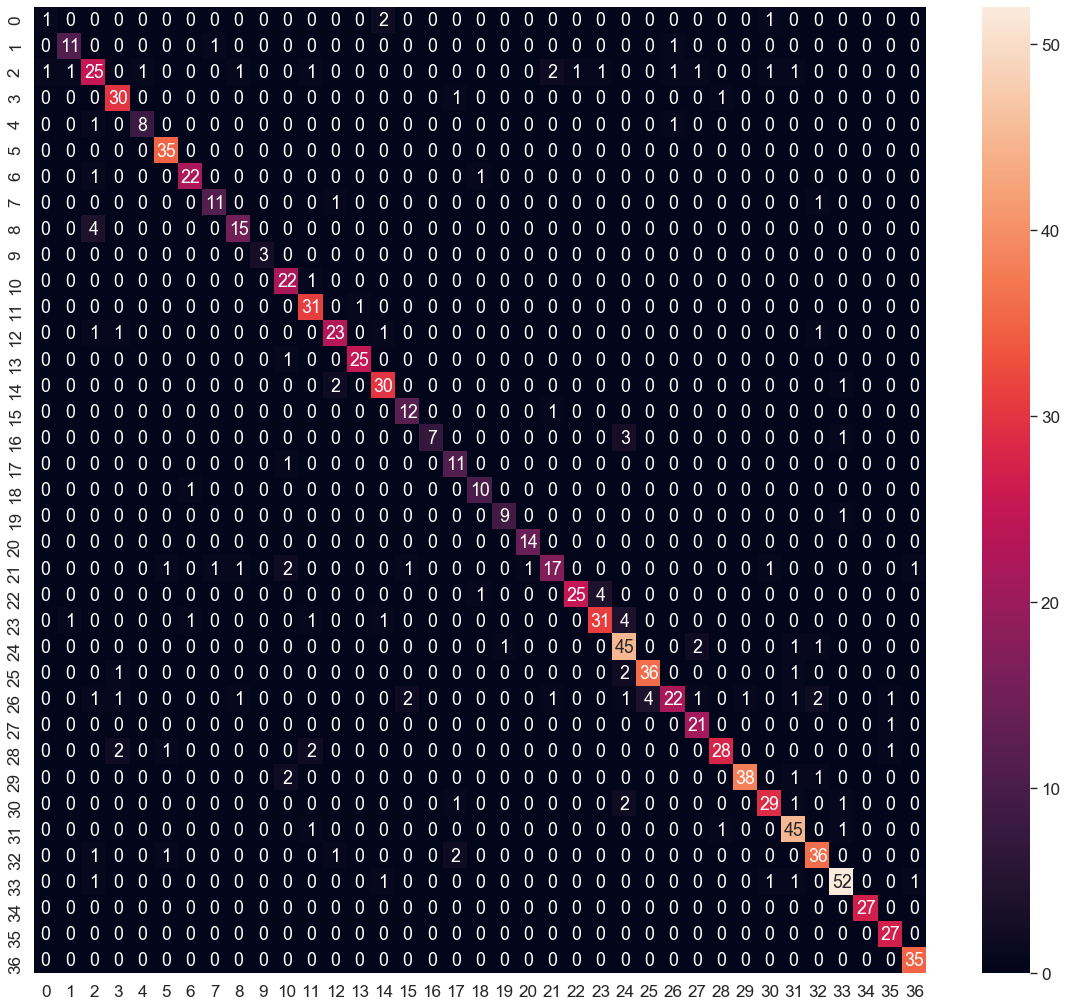

In [94]:
conf_arr = confusion_matrix(test.iloc[:,-1],predictions)#.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(conf_arr)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

#### MLP(Multilayer Perceptron)

Lets fit MLPClassifier with CrossValidation 10 and look at its Accuracy, Confusion Matrix

In [23]:
clf = MLPClassifier(activation='relu',max_iter=2000)
kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
i=1
for train_index, test_index in kf.split(train.iloc[:,:-1],train.iloc[:,-1]):
#     print("TRAIN:", train_index, "TEST:", test_index)
    print()
    print('-------fold '+str(i)+'--------')
    i +=1
    X_train, X_test = train.iloc[train_index,:-1], train.iloc[test_index,:-1]
    y_train, y_test = train.iloc[train_index,-1], train.iloc[test_index,-1]
    

    clf.fit(X_train, y_train.values.ravel())

    #### Accuracy

    predictions = clf.predict(X_test)
    print ("Train Accuracy :: ", accuracy_score(y_train, clf.predict(X_train)))
    print ("Validation Accuracy  :: ", accuracy_score(y_test, predictions))

    #### F1-Score

    print('F1-score: {0}'.format(f1_score(predictions, y_test,average='micro')))


-------fold 1--------
Train Accuracy ::  0.98568281938326
Validation Accuracy  ::  0.8226950354609929
F1-score: 0.8226950354609928

-------fold 2--------
Train Accuracy ::  0.990646492434663
Validation Accuracy  ::  0.819047619047619
F1-score: 0.819047619047619

-------fold 3--------
Train Accuracy ::  0.9802197802197802
Validation Accuracy  ::  0.8120481927710843
F1-score: 0.8120481927710843

-------fold 4--------
Train Accuracy ::  0.9890260631001372
Validation Accuracy  ::  0.8073170731707318
F1-score: 0.8073170731707318

-------fold 5--------
Train Accuracy ::  0.9884963023829088
Validation Accuracy  ::  0.8242574257425742
F1-score: 0.8242574257425741

-------fold 6--------
Train Accuracy ::  0.9822064056939501
Validation Accuracy  ::  0.8034825870646766
F1-score: 0.8034825870646766

-------fold 7--------
Train Accuracy ::  0.9860503282275711
Validation Accuracy  ::  0.7719298245614035
F1-score: 0.7719298245614035

-------fold 8--------
Train Accuracy ::  0.990978676872608
Validat

#### Accuracy

In [96]:
predictions = clf.predict(test.iloc[:,:-1])
print ("Test Accuracy  :: ", accuracy_score(test.iloc[:,-1], predictions))

Test Accuracy  ::  0.8199195171026157


#### F1-Score

In [97]:
print('F1-score: {0}'.format(f1_score(predictions, test.iloc[:,-1],average='micro')))

F1-score: 0.8199195171026156


#### Confusion Matrix

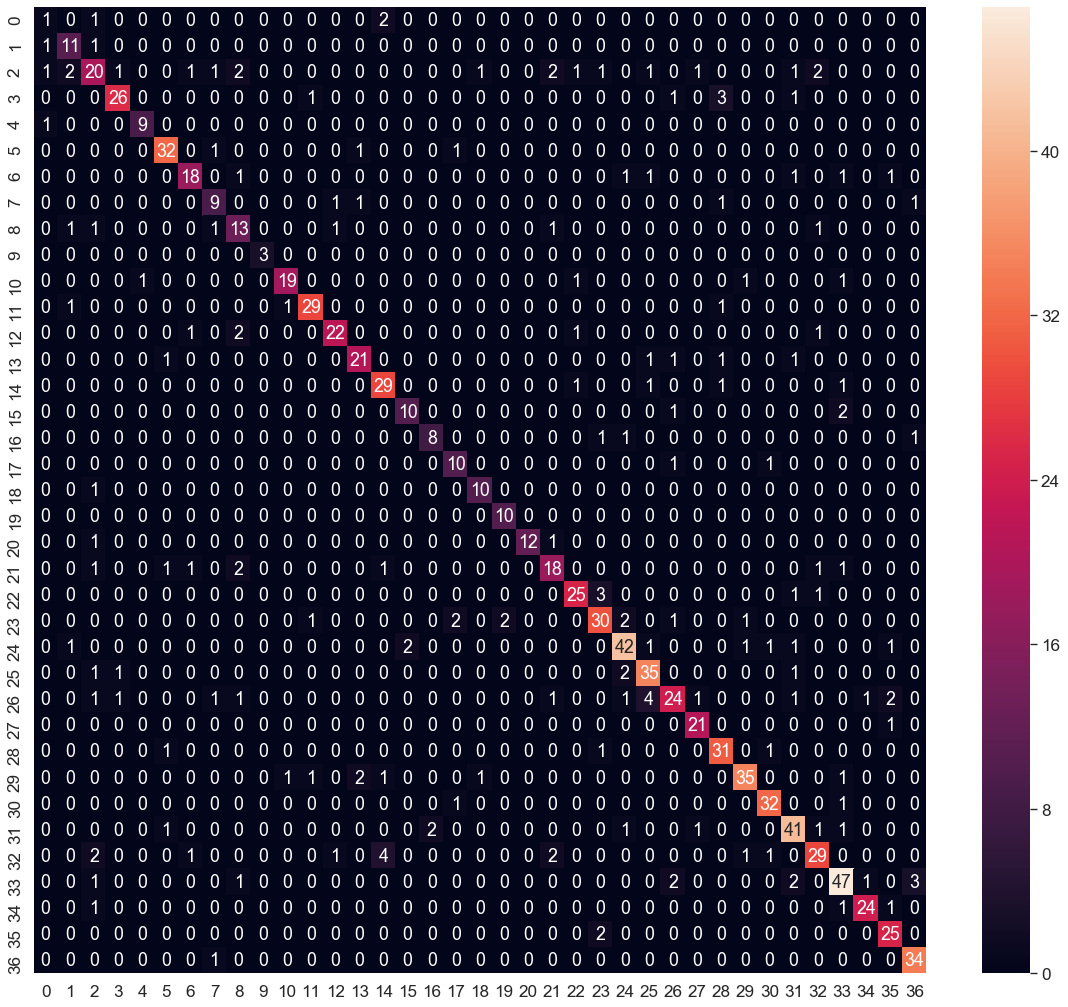

In [98]:
conf_arr = confusion_matrix(test.iloc[:,-1],predictions)#.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(conf_arr)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

#### KNN Classifier

Lets fit KNN Classifier with CrossValidation 10 and look at its Accuracy, Confusion Matrix

In [54]:
clf = KNeighborsClassifier(leaf_size=100,n_neighbors=1)
kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
i=1
for train_index, test_index in kf.split(train.iloc[:,:-1],train.iloc[:,-1]):
#     print("TRAIN:", train_index, "TEST:", test_index)
    print()
    print('-------fold '+str(i)+'--------')
    i +=1
    X_train, X_test = train.iloc[train_index,:-1], train.iloc[test_index,:-1]
    y_train, y_test = train.iloc[train_index,-1], train.iloc[test_index,-1]
    

    clf.fit(X_train, y_train.values.ravel())

    #### Accuracy

    predictions = clf.predict(X_test)
    print ("Train Accuracy :: ", accuracy_score(y_train, clf.predict(X_train)))
    print ("Validation Accuracy  :: ", accuracy_score(y_test, predictions))

    #### F1-Score

    print('F1-score: {0}'.format(f1_score(predictions, y_test,average='micro')))


-------fold 1--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8284424379232506
F1-score: 0.8284424379232506

-------fold 2--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.867579908675799
F1-score: 0.867579908675799

-------fold 3--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8130841121495327
F1-score: 0.8130841121495327

-------fold 4--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8056206088992974
F1-score: 0.8056206088992973

-------fold 5--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8211764705882353
F1-score: 0.8211764705882352

-------fold 6--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8301886792452831
F1-score: 0.8301886792452831

-------fold 7--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8156028368794326
F1-score: 0.8156028368794325

-------fold 8--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8186157517899761
F1-score: 0.8186157517899761

-------fold 9--------
Train Accuracy ::  1.0
Vali

#### Accuracy

In [100]:
predictions = clf.predict(test.iloc[:,:-1])
print ("Test Accuracy  :: ", accuracy_score(test.iloc[:,-1], predictions))

Test Accuracy  ::  0.7575452716297787


#### F1-Score

In [101]:
print('F1-score: {0}'.format(f1_score(predictions, test.iloc[:,-1],average='micro')))

F1-score: 0.7575452716297787


#### Confusion Matrix

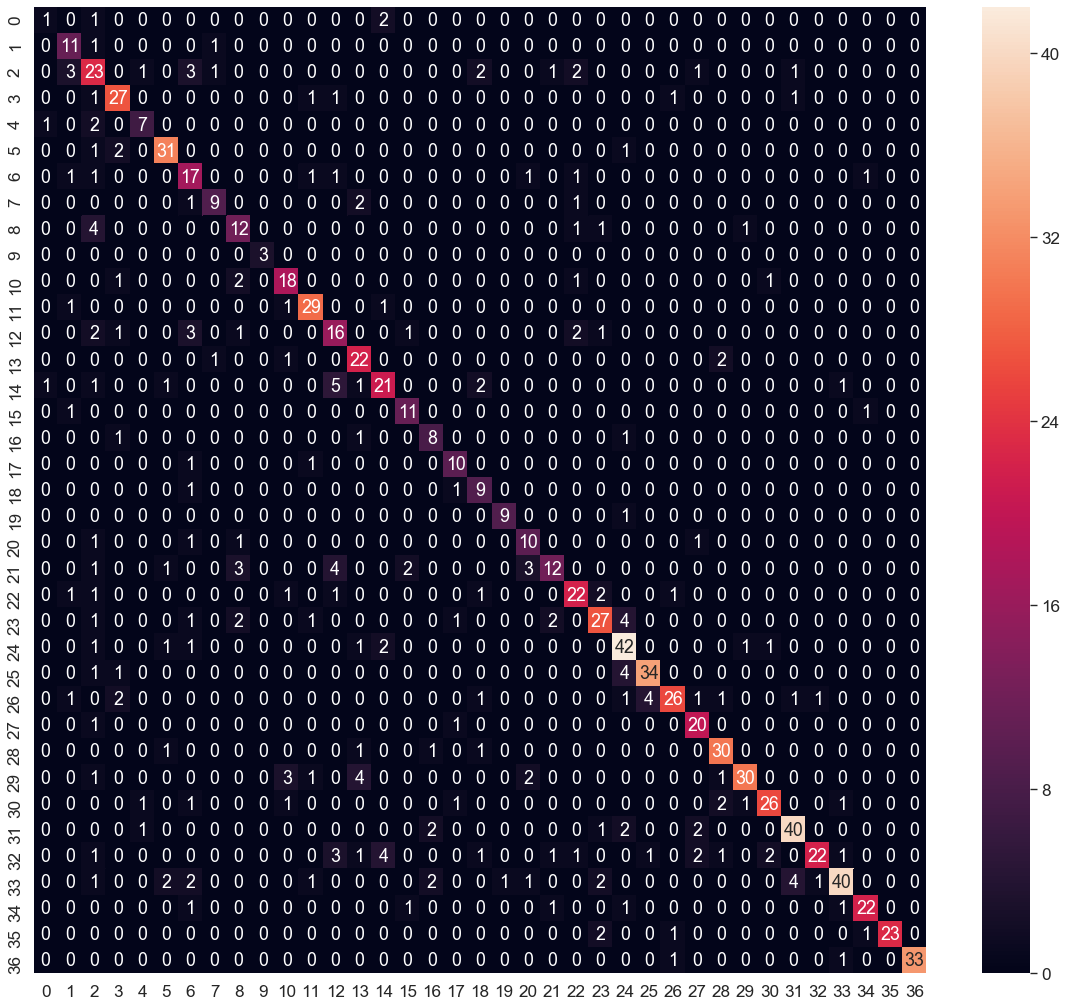

In [102]:
conf_arr = confusion_matrix(test.iloc[:,-1],predictions)#.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(conf_arr)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

#### RBF(SVC)

Lets fit SVC Classifier(RBF) with CrossValidation 10 and look at its Accuracy, Confusion Matrix

In [ ]:
# From Gear1 to Gear15 where accuracy is less than 70%
clf = SVC(kernel='rbf', random_state=0, gamma=.01, C=100000)

#Else use down one
#clf = SVC(gamma='scale', decision_function_shape='ovo')

kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
i=1
for train_index, test_index in kf.split(train.iloc[:,:-1],train.iloc[:,-1]):
#     print("TRAIN:", train_index, "TEST:", test_index)
    print()
    print('-------fold '+str(i)+'--------')
    i +=1
    X_train, X_test = train.iloc[train_index,:-1], train.iloc[test_index,:-1]
    y_train, y_test = train.iloc[train_index,-1], train.iloc[test_index,-1]
    

    clf.fit(X_train, y_train.values.ravel())

    #### Accuracy

    predictions = clf.predict(X_test)
    print ("Train Accuracy :: ", accuracy_score(y_train, clf.predict(X_train)))
    print ("Validation Accuracy  :: ", accuracy_score(y_test, predictions))

    #### F1-Score

    print('F1-score: {0}'.format(f1_score(predictions, y_test,average='micro')))


-------fold 1--------
Train Accuracy ::  0.9581346051934287
Validation Accuracy  ::  0.7895927601809954
F1-score: 0.7895927601809954

-------fold 2--------
Train Accuracy ::  0.9598202484800423
Validation Accuracy  ::  0.789838337182448
F1-score: 0.7898383371824479

-------fold 3--------
Train Accuracy ::  0.9585314315900687
Validation Accuracy  ::  0.8
F1-score: 0.8000000000000002

-------fold 4--------
Train Accuracy ::  0.9588281868566905
Validation Accuracy  ::  0.7868852459016393
F1-score: 0.7868852459016392

-------fold 5--------
Train Accuracy ::  0.959673168160253
Validation Accuracy  ::  0.7985781990521327
F1-score: 0.7985781990521327

-------fold 6--------
Train Accuracy ::  0.9599578503688093
Validation Accuracy  ::  0.7714285714285715
F1-score: 0.7714285714285715

-------fold 7--------


#### Accuracy

In [104]:
predictions = clf.predict(test.iloc[:,:-1])
print ("Test Accuracy  :: ", accuracy_score(test.iloc[:,-1], predictions))

Test Accuracy  ::  0.24245472837022133


#### F1-Score

In [105]:
print('F1-score: {0}'.format(f1_score(predictions, test.iloc[:,-1],average='micro')))

F1-score: 0.24245472837022133


#### Confusion Matrix

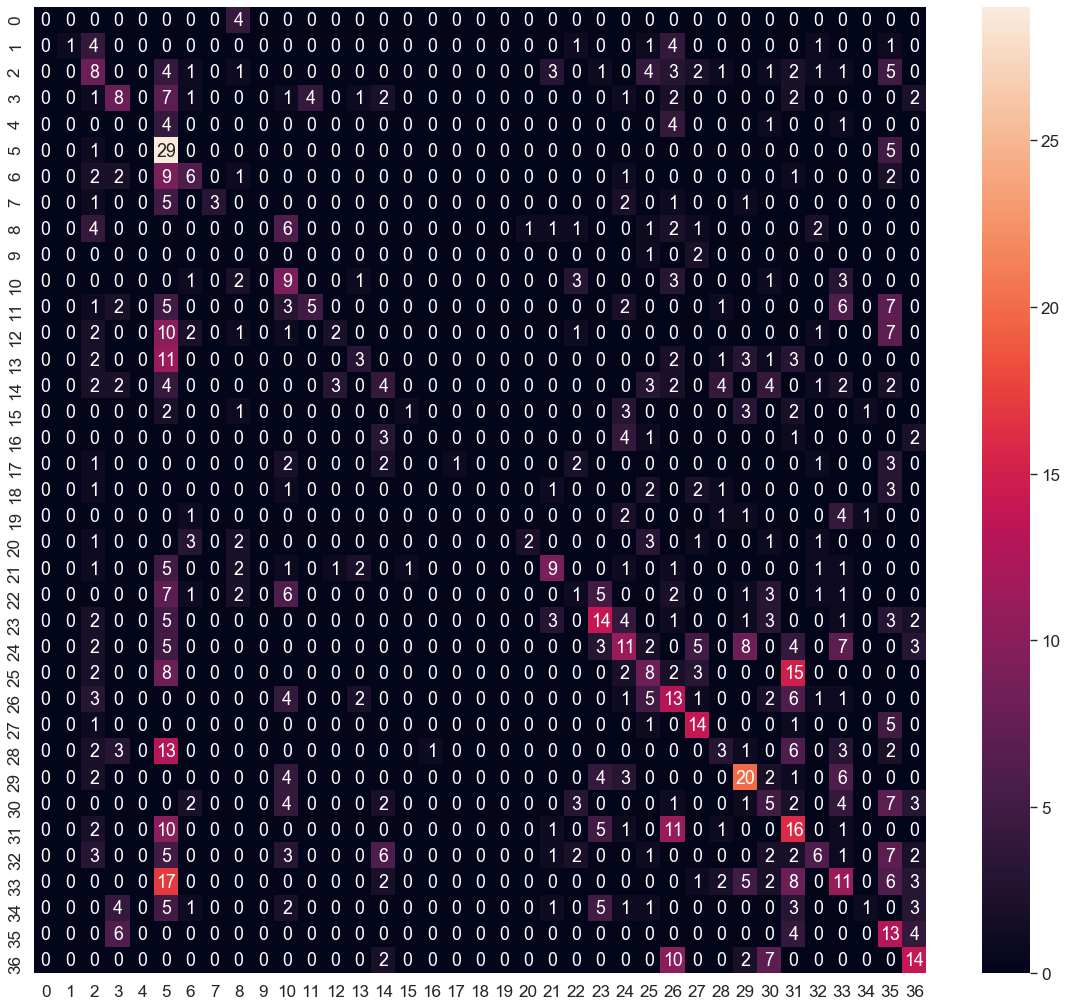

In [106]:
conf_arr = confusion_matrix(test.iloc[:,-1],predictions)#.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(conf_arr)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [74]:
# utils = importr('utils')
# utils.install_packages('RSNNS')

#rsnns = importr('RSNNS')

#model = rsnns.rbf(train_x, train_y.values.ravel(),size=40, maxit = 1000)

In [73]:
#R.predict(model, train_x, classification=True)

In [74]:
# # predictions = model.predict(test_x)
# predictions = R.predict(model, test_x)
# print ("Train Accuracy :: ", accuracy_score(train_y, np.array(R.predict(model, train_x))))
# print ("Test Accuracy  :: ", accuracy_score(test_y, np.array(predictions)))

In [75]:
#predictions

As one can see, all the predictions are just one constant number, which means Radial Basis Fucntion network was not able to train accuratley on this data.

### ROC Curve

For multi class problems like this one, the ROC curve is not a suitable choice to see the output/ accuracy of model, Logistic regression and Binary classification problem do support ROC curve ploting.

In [76]:
# R.par(mfrow=[2,1])
# rsnns.plotIterativeError(model)
# R.plot(train_x, train_y.values.ravel())
# R.lines(train_x, R.fitted(model), col="green")

### Feature selection using fischer score

#### Split Data

Lets create training, test and validation with ratio of 60%, 20%, 20% respectively.

In [53]:
# Y = label_binarize(test_y, classes=gear_ds_fscore['Class'].unique())
train,test = train_test_split(gear_ds_fscore_scaled, test_size=0.2, random_state=1,stratify=gear_ds_fscore_scaled[['Class']])

# train_x, validate_x, train_y, validate_y = train_test_split(train_x, train_y, test_size=0.25, random_state=1,stratify=train_y)
# train, validate, test = np.split(gear_ds_fscore.sample(frac=1), [int(.6*len(gear_ds_fscore)), int(.8*len(gear_ds_fscore))])
# train_x, train_y = train.drop(['Class'],axis=1),train[['Class']]
# validate_x, validate_y = validate.drop(['Class'],axis=1),validate[['Class']]
# test_x, test_y = test.drop(['Class'],axis=1),test[['Class']]

print ("Train Shape :: ", train.shape)
# print ("Train_y Shape :: ", train_y.shape)
print ("Test Shape :: ", test.shape)
# print ("Test_y Shape :: ", test_y.shape)
# print ("validate_x Shape :: ", validate_x.shape)
# print ("validate_x Shape :: ", validate_y.shape)

Train Shape ::  (4216, 33)
Test Shape ::  (1055, 33)


#### Random Forest Classifier

Lets fit RandomForestClassifier with CrossValidation 10 and look at its Accuracy, Confusion Matrix and ROC Curve

In [25]:
clf = RandomForestClassifier(n_estimators=100)

kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
i=1
for train_index, test_index in kf.split(train.iloc[:,:-1],train.iloc[:,-1]):
#     print("TRAIN:", train_index, "TEST:", test_index)
    print()
    print('-------fold '+str(i)+'--------')
    i +=1
    X_train, X_test = train.iloc[train_index,:-1], train.iloc[test_index,:-1]
    y_train, y_test = train.iloc[train_index,-1], train.iloc[test_index,-1]
    

    clf.fit(X_train, y_train.values.ravel())

    #### Accuracy

    predictions = clf.predict(X_test)
    print ("Train Accuracy :: ", accuracy_score(y_train, clf.predict(X_train)))
    print ("Validation Accuracy  :: ", accuracy_score(y_test, predictions))

    #### F1-Score

    print('F1-score: {0}'.format(f1_score(predictions, y_test,average='micro')))


-------fold 1--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.9176755447941889
F1-score: 0.9176755447941889

-------fold 2--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.9148418491484185
F1-score: 0.9148418491484185

-------fold 3--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.914004914004914
F1-score: 0.9140049140049141

-------fold 4--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.896551724137931
F1-score: 0.896551724137931

-------fold 5--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.9223057644110275
F1-score: 0.9223057644110275

-------fold 6--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8911392405063291
F1-score: 0.8911392405063291

-------fold 7--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8954081632653061
F1-score: 0.8954081632653061

-------fold 8--------
Train Accuracy ::  1.0
Validation Accuracy  ::  0.8865979381443299
F1-score: 0.8865979381443299

-------fold 9--------
Train Accuracy ::  1.0
Valid

#### Accuracy

In [109]:
predictions = clf.predict(test.iloc[:,:-1])
print ("Test Accuracy  :: ", accuracy_score(test.iloc[:,-1], predictions))

Test Accuracy  ::  0.9004024144869215


#### F1-Score

In [110]:
print('F1-score: {0}'.format(f1_score(predictions, test.iloc[:,-1],average='micro')))

F1-score: 0.9004024144869215


#### Confusion Matrix

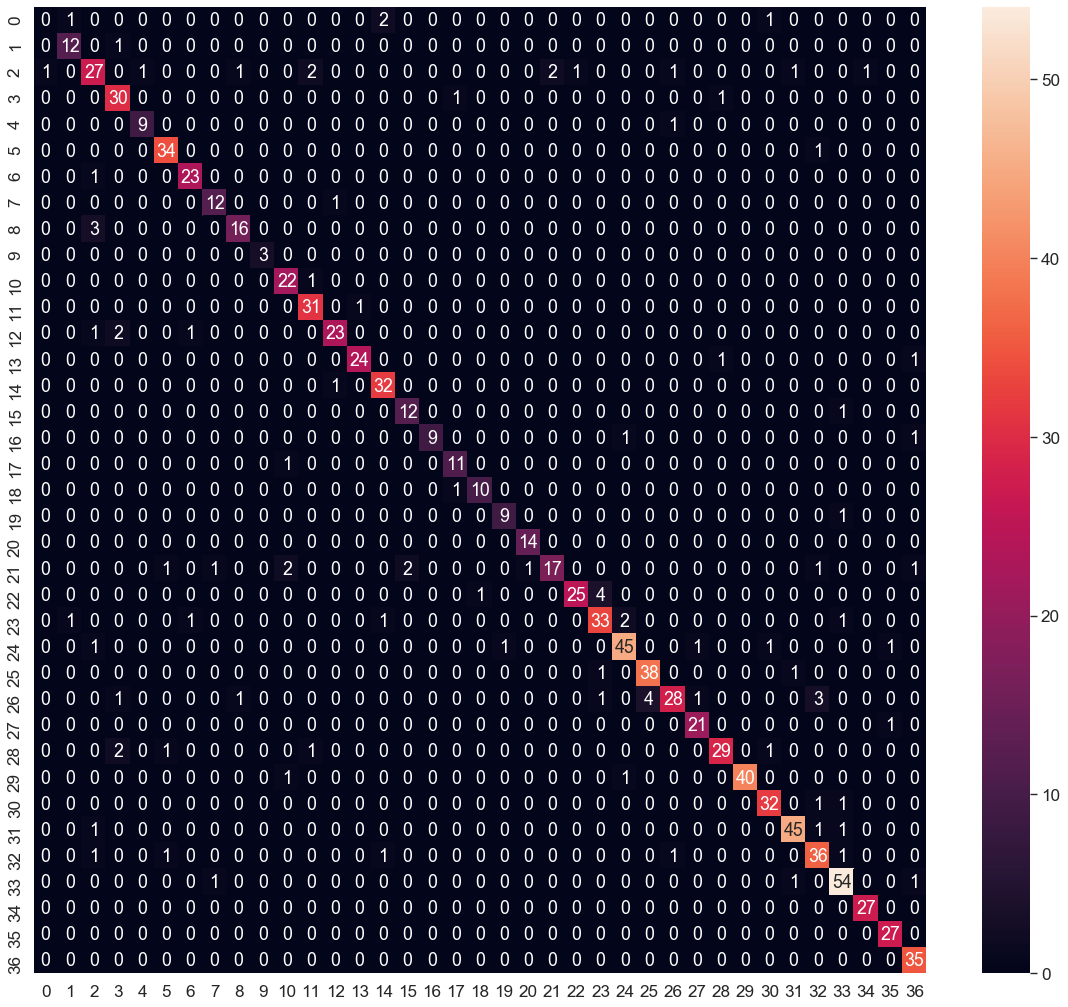

In [111]:
conf_arr = confusion_matrix(test.iloc[:,-1],predictions)#.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(conf_arr)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

#### MLP(Multilayer Perceptron)

Lets fit MLPClassifier with CrossValidation 10 and look at its Accuracy, Confusion Matrix

In [44]:
clf = MLPClassifier(activation='relu',max_iter=2000)
kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
i=1
for train_index, test_index in kf.split(train.iloc[:,:-1],train.iloc[:,-1]):
#     print("TRAIN:", train_index, "TEST:", test_index)
    print()
    print('-------fold '+str(i)+'--------')
    i +=1
    X_train, X_test = train.iloc[train_index,:-1], train.iloc[test_index,:-1]
    y_train, y_test = train.iloc[train_index,-1], train.iloc[test_index,-1]
    

    clf.fit(X_train, y_train.values.ravel())

    #### Accuracy

    predictions = clf.predict(X_test)
    print ("Train Accuracy :: ", accuracy_score(y_train, clf.predict(X_train)))
    print ("Validation Accuracy  :: ", accuracy_score(y_test, predictions))

    #### F1-Score

    print('F1-score: {0}'.format(f1_score(predictions, y_test,average='micro')))


-------fold 1--------
Train Accuracy ::  0.9076661609211625
Validation Accuracy  ::  0.9074456262898872
F1-score: 0.9074456262898872

-------fold 2--------
Train Accuracy ::  0.9077196304551095
Validation Accuracy  ::  0.9076524132091448
F1-score: 0.9076524132091448

-------fold 3--------
Train Accuracy ::  0.9077260538200979
Validation Accuracy  ::  0.9074887536385288
F1-score: 0.9074887536385289

-------fold 4--------
Train Accuracy ::  0.9077025310500565
Validation Accuracy  ::  0.907912146070389
F1-score: 0.907912146070389

-------fold 5--------
Train Accuracy ::  0.9077260538200979
Validation Accuracy  ::  0.9076475258004764
F1-score: 0.9076475258004764

-------fold 6--------
Train Accuracy ::  0.9077025310500565
Validation Accuracy  ::  0.907806297962424
F1-score: 0.907806297962424

-------fold 7--------
Train Accuracy ::  0.9076800940899735
Validation Accuracy  ::  0.907320171492087
F1-score: 0.907320171492087

-------fold 8--------
Train Accuracy ::  0.9075860041164363
Validat

#### Accuracy

In [45]:
predictions = clf.predict(test.iloc[:,:-1])
print ("Test Accuracy  :: ", accuracy_score(test.iloc[:,-1], predictions))

Test Accuracy  ::  0.9078457108984672


#### F1-Score

In [115]:
print('F1-score: {0}'.format(f1_score(predictions, test.iloc[:,-1],average='micro')))

F1-score: 0.8289738430583501


#### Confusion Matrix

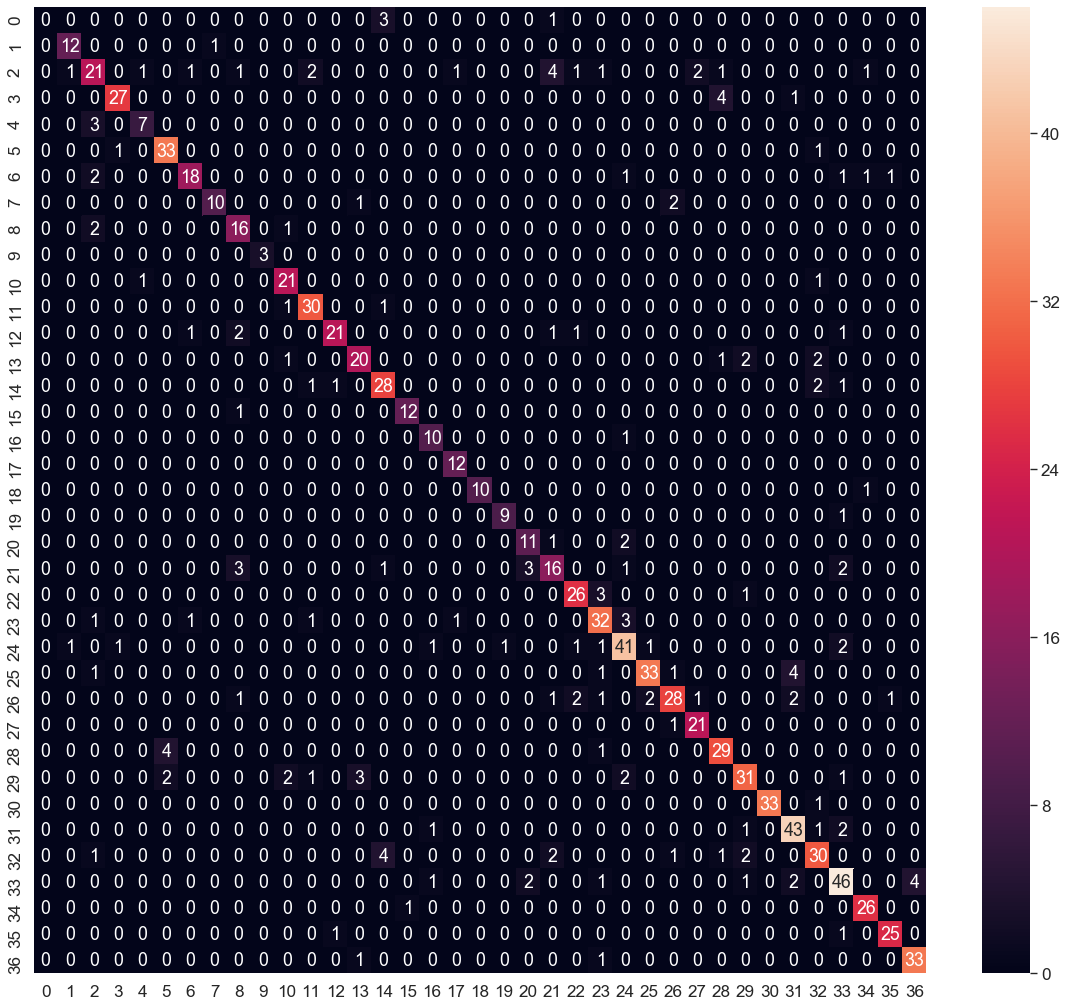

In [116]:
conf_arr = confusion_matrix(test.iloc[:,-1],predictions)#.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(conf_arr)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

#### KNN Classifier

Lets fit KNN Classifier with CrossValidation 10 and look at its Accuracy, Confusion Matrix

In [ ]:
clf = KNeighborsClassifier(leaf_size=100,n_neighbors=5)
kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
i=1
for train_index, test_index in kf.split(train.iloc[:,:-1],train.iloc[:,-1]):
#     print("TRAIN:", train_index, "TEST:", test_index)
    print()
    print('-------fold '+str(i)+'--------')
    i +=1
    X_train, X_test = train.iloc[train_index,:-1], train.iloc[test_index,:-1]
    y_train, y_test = train.iloc[train_index,-1], train.iloc[test_index,-1]
    

    clf.fit(X_train, y_train.values.ravel())

    #### Accuracy

    predictions = clf.predict(X_test)
    print ("Train Accuracy :: ", accuracy_score(y_train, clf.predict(X_train)))
    print ("Validation Accuracy  :: ", accuracy_score(y_test, predictions))

    #### F1-Score

    print('F1-score: {0}'.format(f1_score(predictions, y_test,average='micro')))

#### Accuracy

In [118]:
predictions = clf.predict(test.iloc[:,:-1])
print ("Test Accuracy  :: ", accuracy_score(test.iloc[:,-1], predictions))

Test Accuracy  ::  0.7766599597585513


#### F1-Score

In [119]:
print('F1-score: {0}'.format(f1_score(predictions, test.iloc[:,-1],average='micro')))

F1-score: 0.7766599597585513


#### Confusion Matrix

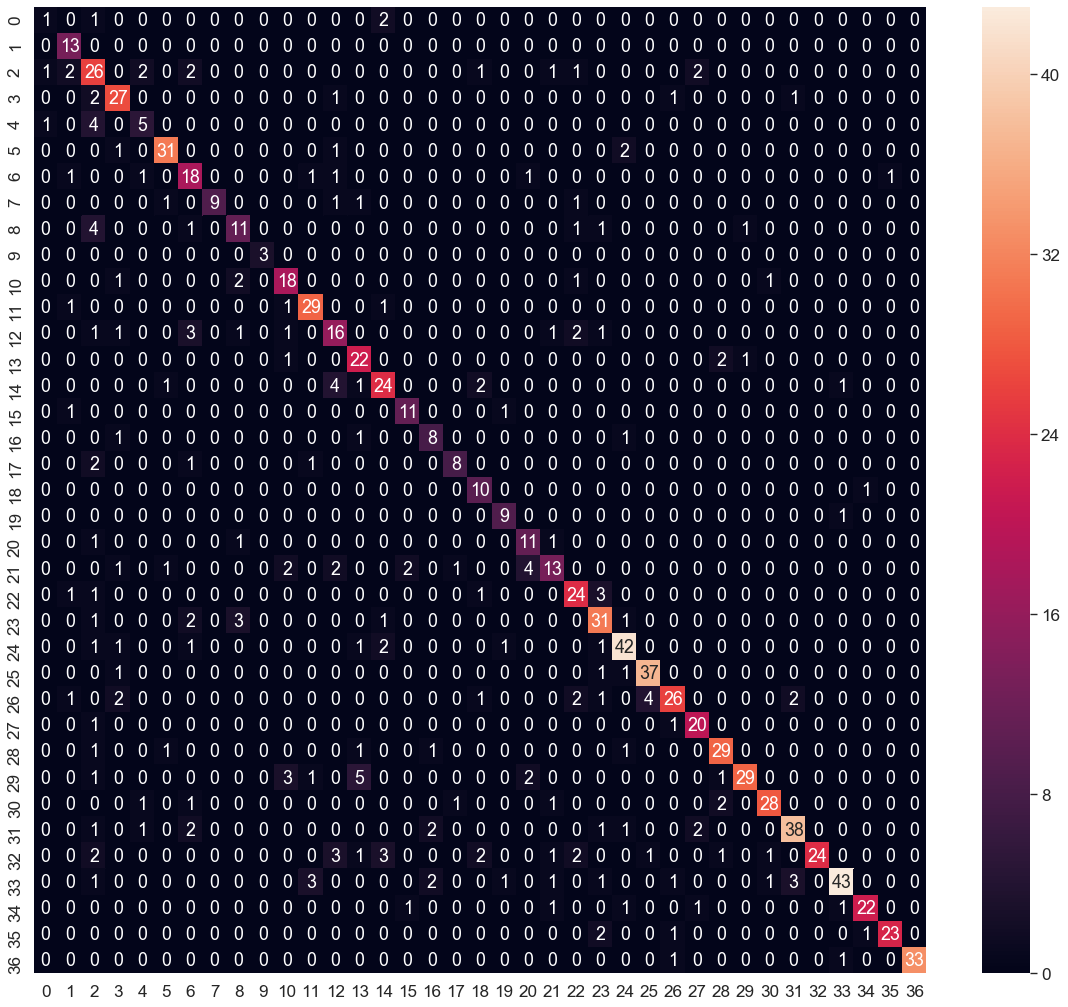

In [120]:
conf_arr = confusion_matrix(test.iloc[:,-1],predictions)#.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(conf_arr)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

#### RBF(SVC)

Lets fit SVC Classifier(RBF) with CrossValidation 10 and look at its Accuracy, Confusion Matrix

In [54]:
# From Gear1 to Gear15 where accuracy is less than 70%
clf = SVC(kernel='rbf', random_state=0, gamma=.01, C=100000)

#Else use down one
#clf = SVC(gamma='scale', decision_function_shape='ovo')

kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
i=1
for train_index, test_index in kf.split(train.iloc[:,:-1],train.iloc[:,-1]):
#     print("TRAIN:", train_index, "TEST:", test_index)
    print()
    print('-------fold '+str(i)+'--------')
    i +=1
    X_train, X_test = train.iloc[train_index,:-1], train.iloc[test_index,:-1]
    y_train, y_test = train.iloc[train_index,-1], train.iloc[test_index,-1]
    

    clf.fit(X_train, y_train.values.ravel())

    #### Accuracy

    predictions = clf.predict(X_test)
    print ("Train Accuracy :: ", accuracy_score(y_train, clf.predict(X_train)))
    print ("Validation Accuracy  :: ", accuracy_score(y_test, predictions))

    #### F1-Score

    print('F1-score: {0}'.format(f1_score(predictions, y_test,average='micro')))


-------fold 1--------
Train Accuracy ::  0.9978802331743508
Validation Accuracy  ::  0.8461538461538461
F1-score: 0.8461538461538461

-------fold 2--------
Train Accuracy ::  0.9984139571768438
Validation Accuracy  ::  0.8729792147806005
F1-score: 0.8729792147806005

-------fold 3--------
Train Accuracy ::  0.9984152139461173
Validation Accuracy  ::  0.827906976744186
F1-score: 0.827906976744186

-------fold 4--------
Train Accuracy ::  0.9970968593296384
Validation Accuracy  ::  0.8665105386416861
F1-score: 0.8665105386416861

-------fold 5--------
Train Accuracy ::  0.9971006852925672
Validation Accuracy  ::  0.8815165876777251
F1-score: 0.8815165876777251

-------fold 6--------
Train Accuracy ::  0.9976290832455216
Validation Accuracy  ::  0.8690476190476191
F1-score: 0.8690476190476191

-------fold 7--------
Train Accuracy ::  0.9981588637559179
Validation Accuracy  ::  0.857487922705314
F1-score: 0.857487922705314

-------fold 8--------
Train Accuracy ::  0.9976334472784644
Valid

#### Accuracy

In [122]:
predictions = clf.predict(test.iloc[:,:-1])
print ("Test Accuracy  :: ", accuracy_score(test.iloc[:,-1], predictions))

Test Accuracy  ::  0.24849094567404426


#### F1-Score

In [123]:
print('F1-score: {0}'.format(f1_score(predictions, test.iloc[:,-1],average='micro')))

F1-score: 0.24849094567404426


#### Confusion Matrix

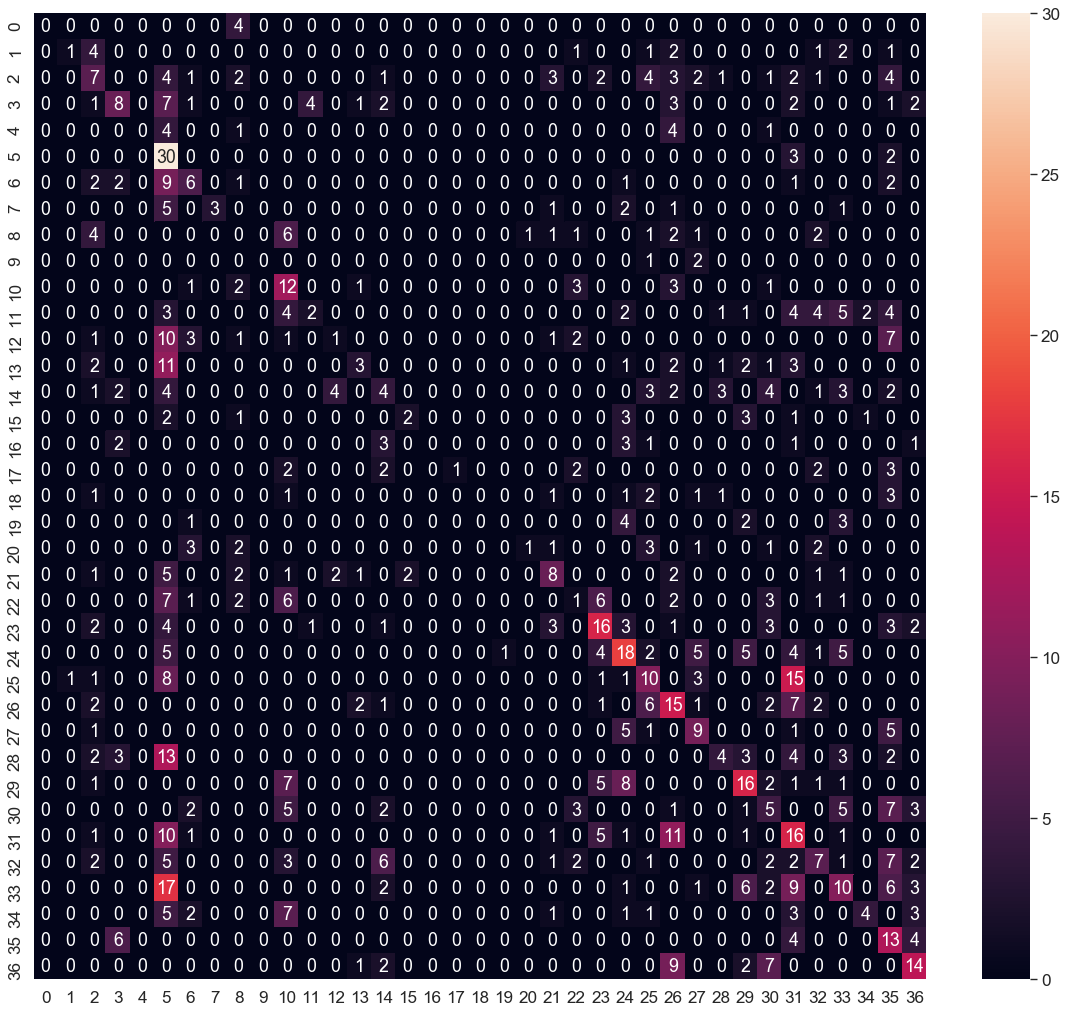

In [124]:
conf_arr = confusion_matrix(test.iloc[:,-1],predictions)#.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(conf_arr)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [77]:
# utils = importr('utils')
# utils.install_packages('RSNNS')

#rsnns = importr('RSNNS')

#model = rsnns.rbf(train_x, train_y.values.ravel(),size=40, maxit = 1000)

In [78]:
#R.predict(model, train_x, classification=True)

In [79]:
# # predictions = model.predict(test_x)
#predictions = R.predict(model, test_x)
# print ("Train Accuracy :: ", accuracy_score(train_y, np.array(R.predict(model, train_x))))
# print ("Test Accuracy  :: ", accuracy_score(test_y, np.array(predictions)))

In [80]:
#predictions

As one can see, all the predictions are just one constant number, which means Radial Basis Fucntion network was not able to train accuratley on this data.

### ROC Curve

For multi class problems like this one, the ROC curve is not a suitable choice to see the output/ accuracy of model, Logistic regression and Binary classification problem do support ROC curve ploting.

In [81]:
# R.par(mfrow=[2,1])
# rsnns.plotIterativeError(model)
# R.plot(train_x, train_y.values.ravel())
# R.lines(train_x, R.fitted(model), col="green")